# Pixel Based Metrics for Classification

### Metrics to calculate

* SLIC distance
* Variance or Standard deviation
* Range
* Mean
* Std, range on gradients
* GLCM 
* GLCM on gradients

In this notebook, the following pixel-based statistical features are calculated.
Images are then tried to be classified based on these features.

#### Computed Features
* Range, mean, std on red, green and blue channel
* range, mean, std on magnitude of Sobel gradients for r, g and b channel
* Energy, correlation, homogeneity on GLCM of grayscale image

In [1]:
import numpy as np
import pandas as pd
from os.path import join
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

import utils

from scipy.ndimage import sobel
from skimage import io

ModuleNotFoundError: No module named 'utils'

In [3]:
# Choose an arbitrary example image
train_dir = join('..', '..', 'data', 'all_in_one2', 'train')
materials = {'concrete_cement':0, 'healthy_metal':1, 'incomplete':2, 'irregular_metal':3, 'other':4}

## 1. Image Overview

### 1.1 Image Channels and Gradient Magnitude Image

In [3]:
train_sample = join(train_dir, 'other', '7a307a06.tif')
img = io.imread(train_sample)

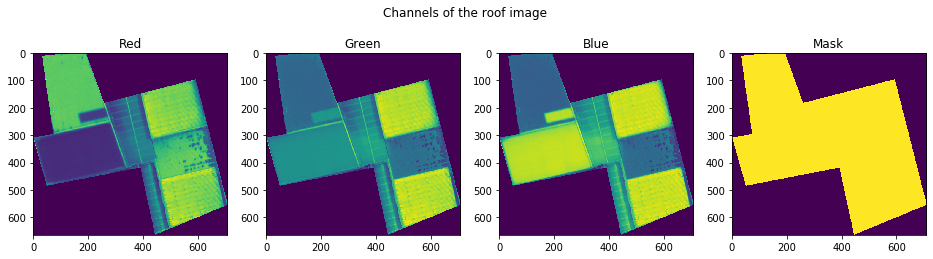

In [4]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (16, 4))
ax1.imshow(img[:, :, 0])
ax1.set_title("Red")
ax2.imshow(img[:, :, 1])
ax2.set_title("Green")
ax3.imshow(img[:, :, 2])
ax3.set_title("Blue")
ax4.imshow(img[:, :, 3])
ax4.set_title("Mask")
fig.suptitle("Channels of the roof image")
plt.show()

### 1.2 Gradient Magnitude Images based on Sobel

In [5]:
def sobel_layers(img):
    sob = np.zeros(img.shape)    
    for layer in range(img.shape[2]):
        sx = sobel(img[:, :, layer].astype('int32'), axis=0, mode='constant')
        sy = sobel(img[:, :, layer].astype('int32'), axis=1, mode='constant')
        sob[:, :, layer] = np.hypot(sx, sy)
    return sob

In [6]:
sob = sobel_layers(img)

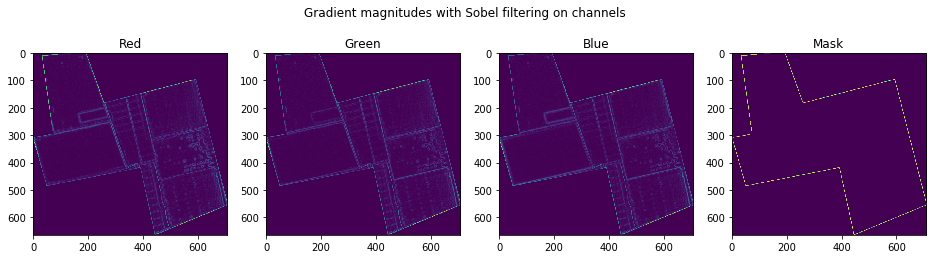

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (16, 4))
ax1.imshow(sob[:, :, 0])
ax1.set_title("Red")
ax2.imshow(sob[:, :, 1])
ax2.set_title("Green")
ax3.imshow(sob[:, :, 2])
ax3.set_title("Blue")
ax4.imshow(sob[:, :, 3])
ax4.set_title("Mask")
fig.suptitle("Gradient magnitudes with Sobel filtering on channels")
plt.show()

## 2. Basic Statistics on Original and Sobel

In [8]:
def statistics(img, sob):
    """ 
    Expects image as numpy array.
    Calculates basic image statistics (variance, std, range, mean)
    """
    # Select only those pixels that belong to the roof (i.e. mask the image)
    img_arr = img[:, :, :3][img[:, :, 3] > 0]

    mean_rgb = img_arr.mean(0)
    std_rgb = img_arr.std(0)
    ptp_rgb = img_arr.ptp(0) #peak-to-peak = range
    
    # Calculate statistics on gradient (Sobel) image
    sob_arr = sob[:, :, :3][sob[:, :, 3] > 0]

    mean_sob = sob_arr.mean(0)
    std_sob = sob_arr.std(0)
    ptp_sob = sob_arr.ptp(0)

    return mean_rgb, std_rgb, ptp_rgb, mean_sob, std_sob, ptp_sob
    

In [9]:
statistics(img, sob)

(array([122.50849686, 128.00176217, 160.67513344]),
 array([61.50303019, 50.7089067 , 64.04417526]),
 array([208, 215, 230], dtype=uint8),
 array([372.88057878, 350.47666225, 384.85624455]),
 array([214.45936847, 190.00321567, 204.72145604]),
 array([ 911.34404435,  968.11600394, 1018.02351439]))

## 3. GLCM features

For textural features, convert the image to grayscale and calculate energy, correlation and homogeneity features

In [10]:
from skimage import io, color, img_as_ubyte
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics.cluster import entropy

def glcm_feats(img):
    grayImg = img_as_ubyte(color.rgb2gray(img))

    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    properties = ['energy', 'correlation', 'homogeneity']

    glcm = greycomatrix(grayImg, 
                        distances=distances, 
                        angles=angles,
                        symmetric=True,
                        normed=True)
    glcm_en = greycoprops(glcm, 'energy')
    glcm_co = greycoprops(glcm, 'correlation')
    glcm_ho = greycoprops(glcm, 'homogeneity')
    
    return glcm_en, glcm_co, glcm_ho

In [11]:
glcm_feats(img)

/root/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


(array([[0.45657526, 0.45457987, 0.45655362, 0.45454307],
        [0.45377064, 0.45457987, 0.45391422, 0.45454307],
        [0.45122036, 0.45025283, 0.45152003, 0.45010432]]),
 array([[0.99424312, 0.99034413, 0.99408965, 0.99084138],
        [0.98758331, 0.99034413, 0.98726268, 0.99084138],
        [0.98110421, 0.97934866, 0.98046471, 0.98050255]]),
 array([[0.70482231, 0.64426255, 0.67765131, 0.6533094 ],
        [0.64289194, 0.64426255, 0.62301505, 0.6533094 ],
        [0.61986296, 0.60328542, 0.6067731 , 0.60719336]]))

## 4. Compute above Features on all labeled images

Walk through all images, compute the features and collect them in a Pandas Dataframe

In [12]:
#train_dir = join('..', '..', 'data', 'data2', 'mixco_3', 'roofs_train')

In [13]:
def calculate_features(train_dir):
    
    # Initialize a dataframe for the features    
    columns = ['id', 'label',
               'mean_rgb', 'std_rgb', 'ptp_rgb',
               'mean_sob', 'std_sob', 'ptp_sob',
               'glcm_en', 'glcm_co', 'glcm_ho']
    df_features = pd.DataFrame(columns=columns)

    data = []
    # Walk through all images
    for material in materials.keys():
        material_fp = join(train_dir, material)
        print(material_fp)
        for root, dirs, files in os.walk(material_fp):
            for file in files:
                img_fp = join(material_fp, file)
                label = materials[material]
                id = file.split('.')[0] # retrieve id from filename
                print(id, "labeled as", material, ":", label)
                
                img = io.imread(img_fp)
                sob = sobel_layers(img)
                
                mean_rgb, std_rgb, ptp_rgb, mean_sob, std_sob, ptp_sob = statistics(img, sob)
                glcm_en, glcm_co, glcm_ho = glcm_feats(img)

                data.append({'id': id ,
                             'mean_r': mean_rgb[0], 'mean_g': mean_rgb[1], 'mean_b': mean_rgb[2],
                             'std_r': std_rgb[0], 'std_g': std_rgb[1], 'std_b': std_rgb[2],
                             'ptp_r': ptp_rgb[0], 'ptp_g': ptp_rgb[1], 'ptp_b': ptp_rgb[2],
                             'mean_sob_r': mean_sob[0], 'mean_sob_g': mean_sob[1], 'mean_sob_b': mean_sob[2],
                             'std_sob_r': std_sob[0], 'std_sob_g': std_sob[1], 'std_sob_b': std_sob[2],
                             'ptp_sob_r': ptp_sob[0], 'ptp_sob_g': ptp_sob[1], 'ptp_sob_b': ptp_sob[2],
                             'glcm_en': glcm_en, 'glcm_co': glcm_co, 'glcm_ho': glcm_ho,
                             'label': label})
    
    df_features = pd.DataFrame(data)
    return df_features

In [21]:
pickle_path = join('..', '..', 'pickles')
compute_anew = True

if compute_anew == True:
    pb_features = calculate_features(train_dir)
    with open(join(pickle_path, 'pb_features.pkl'), 'wb') as f:
        pickle.dump(pb_features, f)

../../data/all_in_one2/train/concrete_cement
7a20f7ac labeled as concrete_cement : 0
7a37c004 labeled as concrete_cement : 0
7a2ad678 labeled as concrete_cement : 0
7a272a78 labeled as concrete_cement : 0
7a38b298 labeled as concrete_cement : 0
7a3b88b0 labeled as concrete_cement : 0
7a441a84 labeled as concrete_cement : 0
7a3a662e labeled as concrete_cement : 0
7a3c5394 labeled as concrete_cement : 0
7a43cf34 labeled as concrete_cement : 0
7a2c3a36 labeled as concrete_cement : 0
7a3d7d28 labeled as concrete_cement : 0
7a397142 labeled as concrete_cement : 0
7a3eaa0e labeled as concrete_cement : 0
7a2beb9e labeled as concrete_cement : 0
7a30cd44 labeled as concrete_cement : 0
7a3542ca labeled as concrete_cement : 0
7a1c51c0 labeled as concrete_cement : 0
7a25ad60 labeled as concrete_cement : 0
7a382b34 labeled as concrete_cement : 0
7a38f03c labeled as concrete_cement : 0
7a238a3a labeled as concrete_cement : 0
7a34584c labeled as concrete_cement : 0
7a2888fa labeled as concrete_cement

7a1dda4a labeled as concrete_cement : 0
7a35781c labeled as concrete_cement : 0
7a304dd8 labeled as concrete_cement : 0
7a2d77c0 labeled as concrete_cement : 0
7a417694 labeled as concrete_cement : 0
7a407b9a labeled as concrete_cement : 0
7a399c26 labeled as concrete_cement : 0
7a422a08 labeled as concrete_cement : 0
7a3037c6 labeled as concrete_cement : 0
7a262164 labeled as concrete_cement : 0
7a3d0d5c labeled as concrete_cement : 0
7a3166a0 labeled as concrete_cement : 0
7a403ad6 labeled as concrete_cement : 0
7a3dfbe0 labeled as concrete_cement : 0
7a3ecf8e labeled as concrete_cement : 0
7a26f0a8 labeled as concrete_cement : 0
7a2de6d8 labeled as concrete_cement : 0
7a1e439a labeled as concrete_cement : 0
7a2d367a labeled as concrete_cement : 0
7a337dc8 labeled as concrete_cement : 0
7a2e924a labeled as concrete_cement : 0
7a3c581c labeled as concrete_cement : 0
7a3b1ace labeled as concrete_cement : 0
7a409c88 labeled as concrete_cement : 0
7a22296a labeled as concrete_cement : 0


7a2257a0 labeled as concrete_cement : 0
7a1e9750 labeled as concrete_cement : 0
7a1c66f6 labeled as concrete_cement : 0
7a20ac66 labeled as concrete_cement : 0
7a1ebe38 labeled as concrete_cement : 0
7a3c0c2c labeled as concrete_cement : 0
7a4080a4 labeled as concrete_cement : 0
7a2bbc14 labeled as concrete_cement : 0
7a2543b6 labeled as concrete_cement : 0
7a262b96 labeled as concrete_cement : 0
7a37b230 labeled as concrete_cement : 0
7a398146 labeled as concrete_cement : 0
7a3f3244 labeled as concrete_cement : 0
7a31d0b8 labeled as concrete_cement : 0
7a349730 labeled as concrete_cement : 0
7a384402 labeled as concrete_cement : 0
7a2165ca labeled as concrete_cement : 0
7a388020 labeled as concrete_cement : 0
7a2e3156 labeled as concrete_cement : 0
7a3b8054 labeled as concrete_cement : 0
7a40c51e labeled as concrete_cement : 0
7a3ed420 labeled as concrete_cement : 0
7a3c1d8e labeled as concrete_cement : 0
7a30047c labeled as concrete_cement : 0
7a339de4 labeled as concrete_cement : 0


7a3b85b8 labeled as concrete_cement : 0
7a449950 labeled as concrete_cement : 0
7a1e338c labeled as concrete_cement : 0
7a4226a2 labeled as concrete_cement : 0
7a2cf9bc labeled as concrete_cement : 0
7a3284ae labeled as concrete_cement : 0
7a28c2de labeled as concrete_cement : 0
7a43c69c labeled as concrete_cement : 0
7a3f0512 labeled as concrete_cement : 0
7a378850 labeled as concrete_cement : 0
7a3370c6 labeled as concrete_cement : 0
7a2ee52e labeled as concrete_cement : 0
7a43c7d2 labeled as concrete_cement : 0
7a2d8ada labeled as concrete_cement : 0
7a221f24 labeled as concrete_cement : 0
7a3f0bb6 labeled as concrete_cement : 0
7a250f7c labeled as concrete_cement : 0
7a41e048 labeled as concrete_cement : 0
7a2d103c labeled as concrete_cement : 0
7a40b420 labeled as concrete_cement : 0
7a3cdf12 labeled as concrete_cement : 0
7a2c02d2 labeled as concrete_cement : 0
7a367276 labeled as concrete_cement : 0
7a28074a labeled as concrete_cement : 0
7a36c6e0 labeled as concrete_cement : 0


7a36aa0c labeled as concrete_cement : 0
7a3e18b4 labeled as concrete_cement : 0
7a2681f4 labeled as concrete_cement : 0
7a3d3a48 labeled as concrete_cement : 0
7a301778 labeled as concrete_cement : 0
7a2ec44a labeled as concrete_cement : 0
7a257e1c labeled as concrete_cement : 0
7a3dbacc labeled as concrete_cement : 0
7a35d23a labeled as concrete_cement : 0
7a1cf27e labeled as concrete_cement : 0
7a28667c labeled as concrete_cement : 0
7a3d49f2 labeled as concrete_cement : 0
7a2c9c56 labeled as concrete_cement : 0
7a253c22 labeled as concrete_cement : 0
7a388458 labeled as concrete_cement : 0
7a41510a labeled as concrete_cement : 0
7a2d17b2 labeled as concrete_cement : 0
7a36bf42 labeled as concrete_cement : 0
7a2c9d32 labeled as concrete_cement : 0
7a3c81ac labeled as concrete_cement : 0
7a2544f6 labeled as concrete_cement : 0
7a32004c labeled as concrete_cement : 0
7a37978c labeled as concrete_cement : 0
7a2c07aa labeled as concrete_cement : 0
7a20fcc0 labeled as concrete_cement : 0


7a3ae770 labeled as concrete_cement : 0
7a2f2804 labeled as concrete_cement : 0
7a2e4b32 labeled as concrete_cement : 0
7a1e9192 labeled as concrete_cement : 0
7a2bac6a labeled as concrete_cement : 0
7a2d02ea labeled as concrete_cement : 0
7a355350 labeled as concrete_cement : 0
7a449e5a labeled as concrete_cement : 0
7a239a66 labeled as concrete_cement : 0
7a315c50 labeled as concrete_cement : 0
7a3baf02 labeled as concrete_cement : 0
7a1e7158 labeled as concrete_cement : 0
7a2318f2 labeled as concrete_cement : 0
7a23ab64 labeled as concrete_cement : 0
7a24d5e8 labeled as concrete_cement : 0
7a25838a labeled as concrete_cement : 0
7a24e718 labeled as concrete_cement : 0
7a2bb426 labeled as concrete_cement : 0
7a31d612 labeled as concrete_cement : 0
7a253218 labeled as concrete_cement : 0
7a2abc10 labeled as concrete_cement : 0
7a24b78e labeled as concrete_cement : 0
7a34d7fe labeled as concrete_cement : 0
7a1ca080 labeled as concrete_cement : 0
7a32916a labeled as concrete_cement : 0


7a3ce462 labeled as concrete_cement : 0
7a2e09f6 labeled as concrete_cement : 0
7a3fb5fc labeled as concrete_cement : 0
7a271736 labeled as concrete_cement : 0
7a1e2ea0 labeled as concrete_cement : 0
7a2b5f6c labeled as concrete_cement : 0
7a4000c0 labeled as concrete_cement : 0
7a1cdf3c labeled as concrete_cement : 0
7a42b34c labeled as concrete_cement : 0
7a20f39c labeled as concrete_cement : 0
7a34ff36 labeled as concrete_cement : 0
7a384236 labeled as concrete_cement : 0
7a30b7c8 labeled as concrete_cement : 0
7a2f5e50 labeled as concrete_cement : 0
7a3adf28 labeled as concrete_cement : 0
7a3e2282 labeled as concrete_cement : 0
7a1f1d10 labeled as concrete_cement : 0
7a2139a6 labeled as concrete_cement : 0
7a2de020 labeled as concrete_cement : 0
7a4437b2 labeled as concrete_cement : 0
7a2dd30a labeled as concrete_cement : 0
7a40daa4 labeled as concrete_cement : 0
7a2d31f2 labeled as concrete_cement : 0
7a3951f8 labeled as concrete_cement : 0
7a2b4ae0 labeled as concrete_cement : 0


7a3c50a6 labeled as healthy_metal : 1
7a2d07e0 labeled as healthy_metal : 1
7a33fa14 labeled as healthy_metal : 1
7a3dc986 labeled as healthy_metal : 1
7a44a030 labeled as healthy_metal : 1
7a3933ee labeled as healthy_metal : 1
7a20c1e2 labeled as healthy_metal : 1
7a3867e8 labeled as healthy_metal : 1
7a3372ce labeled as healthy_metal : 1
7a24edf8 labeled as healthy_metal : 1
7a25a284 labeled as healthy_metal : 1
7a229170 labeled as healthy_metal : 1
7a25b986 labeled as healthy_metal : 1
7a28a31c labeled as healthy_metal : 1
7a413e5e labeled as healthy_metal : 1
7a3b980a labeled as healthy_metal : 1
7a245262 labeled as healthy_metal : 1
7a2eeea2 labeled as healthy_metal : 1
7a3665f6 labeled as healthy_metal : 1
7a25da56 labeled as healthy_metal : 1
7a2ae6ea labeled as healthy_metal : 1
7a1e3f94 labeled as healthy_metal : 1
7a3c0812 labeled as healthy_metal : 1
7a298052 labeled as healthy_metal : 1
7a401efc labeled as healthy_metal : 1
7a39f78e labeled as healthy_metal : 1
7a2d8274 lab

7a425e4c labeled as healthy_metal : 1
7a397796 labeled as healthy_metal : 1
7a220d0e labeled as healthy_metal : 1
7a3e74a8 labeled as healthy_metal : 1
7a208dbc labeled as healthy_metal : 1
7a250a68 labeled as healthy_metal : 1
7a2c2f00 labeled as healthy_metal : 1
7a3ba930 labeled as healthy_metal : 1
7a357542 labeled as healthy_metal : 1
7a299754 labeled as healthy_metal : 1
7a281762 labeled as healthy_metal : 1
7a37afa6 labeled as healthy_metal : 1
7a307cb8 labeled as healthy_metal : 1
7a3f347e labeled as healthy_metal : 1
7a2d6816 labeled as healthy_metal : 1
7a255252 labeled as healthy_metal : 1
7a371f32 labeled as healthy_metal : 1
7a44a472 labeled as healthy_metal : 1
7a3b4846 labeled as healthy_metal : 1
7a3508b4 labeled as healthy_metal : 1
7a35fc06 labeled as healthy_metal : 1
7a3d43c6 labeled as healthy_metal : 1
7a1f59ec labeled as healthy_metal : 1
7a36b204 labeled as healthy_metal : 1
7a28ae70 labeled as healthy_metal : 1
7a3d26e8 labeled as healthy_metal : 1
7a2205ac lab

7a2abf4e labeled as healthy_metal : 1
7a3919ae labeled as healthy_metal : 1
7a2e722e labeled as healthy_metal : 1
7a3eefaa labeled as healthy_metal : 1
7a2ae4ce labeled as healthy_metal : 1
7a3c182a labeled as healthy_metal : 1
7a3c33e6 labeled as healthy_metal : 1
7a3e4f32 labeled as healthy_metal : 1
7a2b748e labeled as healthy_metal : 1
7a38f10e labeled as healthy_metal : 1
7a3e276e labeled as healthy_metal : 1
7a37c068 labeled as healthy_metal : 1
7a23d1f2 labeled as healthy_metal : 1
7a447970 labeled as healthy_metal : 1
7a42fe60 labeled as healthy_metal : 1
7a209a32 labeled as healthy_metal : 1
7a230a1a labeled as healthy_metal : 1
7a394654 labeled as healthy_metal : 1
7a242ef4 labeled as healthy_metal : 1
7a2cb5ba labeled as healthy_metal : 1
7a2f8e5c labeled as healthy_metal : 1
7a3349ac labeled as healthy_metal : 1
7a21d096 labeled as healthy_metal : 1
7a1ec37e labeled as healthy_metal : 1
7a39179c labeled as healthy_metal : 1
7a22d040 labeled as healthy_metal : 1
7a1dcb4a lab

7a3db784 labeled as healthy_metal : 1
7a2cc532 labeled as healthy_metal : 1
7a417202 labeled as healthy_metal : 1
7a3cf20e labeled as healthy_metal : 1
7a3a24de labeled as healthy_metal : 1
7a2fb8f0 labeled as healthy_metal : 1
7a1d6e8e labeled as healthy_metal : 1
7a226524 labeled as healthy_metal : 1
7a3fa06c labeled as healthy_metal : 1
7a3a943c labeled as healthy_metal : 1
7a29a4ba labeled as healthy_metal : 1
7a28856c labeled as healthy_metal : 1
7a41bf96 labeled as healthy_metal : 1
7a30215a labeled as healthy_metal : 1
7a4326ce labeled as healthy_metal : 1
7a39c660 labeled as healthy_metal : 1
7a29a23a labeled as healthy_metal : 1
7a2bf300 labeled as healthy_metal : 1
7a3981b4 labeled as healthy_metal : 1
7a320d4e labeled as healthy_metal : 1
7a4225c6 labeled as healthy_metal : 1
7a42b3ba labeled as healthy_metal : 1
7a262088 labeled as healthy_metal : 1
7a3bd810 labeled as healthy_metal : 1
7a33823c labeled as healthy_metal : 1
7a21b142 labeled as healthy_metal : 1
7a29a80c lab

7a269c48 labeled as healthy_metal : 1
7a2ec30a labeled as healthy_metal : 1
7a3f4dec labeled as healthy_metal : 1
7a3fe4c8 labeled as healthy_metal : 1
7a2b96e4 labeled as healthy_metal : 1
7a23a11e labeled as healthy_metal : 1
7a351b4c labeled as healthy_metal : 1
7a2df59c labeled as healthy_metal : 1
7a4466f6 labeled as healthy_metal : 1
7a1f11a8 labeled as healthy_metal : 1
7a2e1374 labeled as healthy_metal : 1
7a33d49e labeled as healthy_metal : 1
7a33af8c labeled as healthy_metal : 1
7a39cfe8 labeled as healthy_metal : 1
7a3f31d6 labeled as healthy_metal : 1
7a1df2e6 labeled as healthy_metal : 1
7a2ab580 labeled as healthy_metal : 1
7a393114 labeled as healthy_metal : 1
7a343916 labeled as healthy_metal : 1
7a357cae labeled as healthy_metal : 1
7a1f3ca0 labeled as healthy_metal : 1
7a3e3984 labeled as healthy_metal : 1
7a277ac8 labeled as healthy_metal : 1
7a3b6dee labeled as healthy_metal : 1
7a234b42 labeled as healthy_metal : 1
7a3ceb74 labeled as healthy_metal : 1
7a3c77d4 lab

7a37a7fe labeled as healthy_metal : 1
7a1e8a4e labeled as healthy_metal : 1
7a3e68be labeled as healthy_metal : 1
7a21dbfe labeled as healthy_metal : 1
7a2d4d04 labeled as healthy_metal : 1
7a349456 labeled as healthy_metal : 1
7a1d80f4 labeled as healthy_metal : 1
7a4444be labeled as healthy_metal : 1
7a36436e labeled as healthy_metal : 1
7a31c6cc labeled as healthy_metal : 1
7a2a6152 labeled as healthy_metal : 1
7a27da18 labeled as healthy_metal : 1
7a3c2004 labeled as healthy_metal : 1
7a39c2aa labeled as healthy_metal : 1
7a2791d4 labeled as healthy_metal : 1
7a2b7f4c labeled as healthy_metal : 1
7a25c46c labeled as healthy_metal : 1
7a3a545e labeled as healthy_metal : 1
7a1c4d74 labeled as healthy_metal : 1
7a27889c labeled as healthy_metal : 1
7a364300 labeled as healthy_metal : 1
7a38b162 labeled as healthy_metal : 1
7a318356 labeled as healthy_metal : 1
7a254a00 labeled as healthy_metal : 1
7a3ad578 labeled as healthy_metal : 1
7a3a9e46 labeled as healthy_metal : 1
7a3152e6 lab

7a363b44 labeled as healthy_metal : 1
7a266066 labeled as healthy_metal : 1
7a310188 labeled as healthy_metal : 1
7a40034a labeled as healthy_metal : 1
7a1fa4ec labeled as healthy_metal : 1
7a3583ac labeled as healthy_metal : 1
7a28b44c labeled as healthy_metal : 1
7a321dc0 labeled as healthy_metal : 1
7a225afc labeled as healthy_metal : 1
7a42bbb2 labeled as healthy_metal : 1
7a1da782 labeled as healthy_metal : 1
7a40f4bc labeled as healthy_metal : 1
7a2e3fd4 labeled as healthy_metal : 1
7a32240a labeled as healthy_metal : 1
7a3f7be6 labeled as healthy_metal : 1
7a350a62 labeled as healthy_metal : 1
7a42749a labeled as healthy_metal : 1
7a4281a6 labeled as healthy_metal : 1
7a1eaa92 labeled as healthy_metal : 1
7a242b84 labeled as healthy_metal : 1
7a3a225e labeled as healthy_metal : 1
7a32adbc labeled as healthy_metal : 1
7a30f0e4 labeled as healthy_metal : 1
7a25c034 labeled as healthy_metal : 1
7a206c38 labeled as healthy_metal : 1
7a342a20 labeled as healthy_metal : 1
7a26c90c lab

7a2630a0 labeled as healthy_metal : 1
7a3f8e6a labeled as healthy_metal : 1
7a3ef5d6 labeled as healthy_metal : 1
7a38d610 labeled as healthy_metal : 1
7a43ef32 labeled as healthy_metal : 1
7a298d86 labeled as healthy_metal : 1
7a3b4e0e labeled as healthy_metal : 1
7a3fb6d8 labeled as healthy_metal : 1
7a34fd2e labeled as healthy_metal : 1
7a203a38 labeled as healthy_metal : 1
7a3a9dd8 labeled as healthy_metal : 1
7a284e3a labeled as healthy_metal : 1
7a2c346e labeled as healthy_metal : 1
7a38a8a2 labeled as healthy_metal : 1
7a293fb6 labeled as healthy_metal : 1
7a3e3506 labeled as healthy_metal : 1
7a320826 labeled as healthy_metal : 1
7a4195c0 labeled as healthy_metal : 1
7a42721a labeled as healthy_metal : 1
7a38fcb2 labeled as healthy_metal : 1
7a3c6654 labeled as healthy_metal : 1
7a277a5a labeled as healthy_metal : 1
7a42cd0a labeled as healthy_metal : 1
7a22a87c labeled as healthy_metal : 1
7a2c1538 labeled as healthy_metal : 1
7a1ffc44 labeled as healthy_metal : 1
7a40d176 lab

7a2d2572 labeled as healthy_metal : 1
7a26754c labeled as healthy_metal : 1
7a369abc labeled as healthy_metal : 1
7a27fe62 labeled as healthy_metal : 1
7a2de458 labeled as healthy_metal : 1
7a43babc labeled as healthy_metal : 1
7a3bec42 labeled as healthy_metal : 1
7a2fc8fe labeled as healthy_metal : 1
7a25ed02 labeled as healthy_metal : 1
7a2d7892 labeled as healthy_metal : 1
7a366ba0 labeled as healthy_metal : 1
7a3ff260 labeled as healthy_metal : 1
7a3c5b0a labeled as healthy_metal : 1
7a242300 labeled as healthy_metal : 1
7a2c005c labeled as healthy_metal : 1
7a39c52a labeled as healthy_metal : 1
7a31c80c labeled as healthy_metal : 1
7a2fa798 labeled as healthy_metal : 1
7a4098d2 labeled as healthy_metal : 1
7a2d8ce2 labeled as healthy_metal : 1
7a32e12e labeled as healthy_metal : 1
7a23e2aa labeled as healthy_metal : 1
7a3ba8c2 labeled as healthy_metal : 1
7a29d1ec labeled as healthy_metal : 1
7a1e8490 labeled as healthy_metal : 1
7a3a1e94 labeled as healthy_metal : 1
7a3b2a46 lab

7a2d042a labeled as healthy_metal : 1
7a2bce0c labeled as healthy_metal : 1
7a1d6894 labeled as healthy_metal : 1
7a2f25fc labeled as healthy_metal : 1
7a33b3a6 labeled as healthy_metal : 1
7a3380fc labeled as healthy_metal : 1
7a291ec8 labeled as healthy_metal : 1
7a2533c6 labeled as healthy_metal : 1
7a1ef132 labeled as healthy_metal : 1
7a27dbc6 labeled as healthy_metal : 1
7a42fbe0 labeled as healthy_metal : 1
7a1db376 labeled as healthy_metal : 1
7a3d3eda labeled as healthy_metal : 1
7a43ade2 labeled as healthy_metal : 1
7a33312e labeled as healthy_metal : 1
7a34a27a labeled as healthy_metal : 1
7a223428 labeled as healthy_metal : 1
7a21d302 labeled as healthy_metal : 1
7a3fffe4 labeled as healthy_metal : 1
7a431be8 labeled as healthy_metal : 1
7a42977c labeled as healthy_metal : 1
7a3ef4a0 labeled as healthy_metal : 1
7a3f595e labeled as healthy_metal : 1
7a3bb326 labeled as healthy_metal : 1
7a396bd4 labeled as healthy_metal : 1
7a391594 labeled as healthy_metal : 1
7a2cf94e lab

7a289f52 labeled as healthy_metal : 1
7a1fec86 labeled as healthy_metal : 1
7a3bcf82 labeled as healthy_metal : 1
7a2cc78a labeled as healthy_metal : 1
7a2e99ca labeled as healthy_metal : 1
7a23aaf6 labeled as healthy_metal : 1
7a1d7352 labeled as healthy_metal : 1
7a301b06 labeled as healthy_metal : 1
7a38f17c labeled as healthy_metal : 1
7a380794 labeled as healthy_metal : 1
7a3862d4 labeled as healthy_metal : 1
7a2d958e labeled as healthy_metal : 1
7a3ce17e labeled as healthy_metal : 1
7a33e434 labeled as healthy_metal : 1
7a3ada0a labeled as healthy_metal : 1
7a3a853c labeled as healthy_metal : 1
7a316844 labeled as healthy_metal : 1
7a21ad46 labeled as healthy_metal : 1
7a35b28c labeled as healthy_metal : 1
7a249222 labeled as healthy_metal : 1
7a40dfae labeled as healthy_metal : 1
7a243a98 labeled as healthy_metal : 1
7a3431a0 labeled as healthy_metal : 1
7a228310 labeled as healthy_metal : 1
7a3d5d3e labeled as healthy_metal : 1
7a420906 labeled as healthy_metal : 1
7a2e4330 lab

7a28d6fc labeled as healthy_metal : 1
7a1ebc1c labeled as healthy_metal : 1
7a359fb8 labeled as healthy_metal : 1
7a3b1704 labeled as healthy_metal : 1
7a221326 labeled as healthy_metal : 1
7a3f3fbe labeled as healthy_metal : 1
7a3cb9ba labeled as healthy_metal : 1
7a20d27c labeled as healthy_metal : 1
7a31fe30 labeled as healthy_metal : 1
7a2659ae labeled as healthy_metal : 1
7a40bfba labeled as healthy_metal : 1
7a30281c labeled as healthy_metal : 1
7a2de08e labeled as healthy_metal : 1
7a314422 labeled as healthy_metal : 1
7a1d2eba labeled as healthy_metal : 1
7a2d0844 labeled as healthy_metal : 1
7a21d3d4 labeled as healthy_metal : 1
7a4263c4 labeled as healthy_metal : 1
7a40d536 labeled as healthy_metal : 1
7a1dba7e labeled as healthy_metal : 1
7a3b0962 labeled as healthy_metal : 1
7a353758 labeled as healthy_metal : 1
7a3688a6 labeled as healthy_metal : 1
7a36541c labeled as healthy_metal : 1
7a27a07a labeled as healthy_metal : 1
7a3def38 labeled as healthy_metal : 1
7a32fb64 lab

7a267e98 labeled as healthy_metal : 1
7a1fee34 labeled as healthy_metal : 1
7a20a23e labeled as healthy_metal : 1
7a1e5a60 labeled as healthy_metal : 1
7a33f9b0 labeled as healthy_metal : 1
7a1d0b88 labeled as healthy_metal : 1
7a395a4a labeled as healthy_metal : 1
7a2dd378 labeled as healthy_metal : 1
7a3b6c4a labeled as healthy_metal : 1
7a2e2b0c labeled as healthy_metal : 1
7a313d9c labeled as healthy_metal : 1
7a347a52 labeled as healthy_metal : 1
7a40249c labeled as healthy_metal : 1
7a2a1440 labeled as healthy_metal : 1
7a442754 labeled as healthy_metal : 1
7a267ac4 labeled as healthy_metal : 1
7a2b14f8 labeled as healthy_metal : 1
7a33d156 labeled as healthy_metal : 1
7a2e97ae labeled as healthy_metal : 1
7a2fd06a labeled as healthy_metal : 1
7a3c68de labeled as healthy_metal : 1
7a346bde labeled as healthy_metal : 1
7a342b60 labeled as healthy_metal : 1
7a1db4fc labeled as healthy_metal : 1
7a2728ca labeled as healthy_metal : 1
7a1cddfc labeled as healthy_metal : 1
7a276e34 lab

7a3b8702 labeled as healthy_metal : 1
7a25d984 labeled as healthy_metal : 1
7a3dfe56 labeled as healthy_metal : 1
7a42bd6a labeled as healthy_metal : 1
7a2634ba labeled as healthy_metal : 1
7a25d4f2 labeled as healthy_metal : 1
7a424254 labeled as healthy_metal : 1
7a31b63c labeled as healthy_metal : 1
7a443334 labeled as healthy_metal : 1
7a3edbf0 labeled as healthy_metal : 1
7a3a81ea labeled as healthy_metal : 1
7a3e497e labeled as healthy_metal : 1
7a42a50a labeled as healthy_metal : 1
7a27b6a0 labeled as healthy_metal : 1
7a41e886 labeled as healthy_metal : 1
7a1e466a labeled as healthy_metal : 1
7a2fc4da labeled as healthy_metal : 1
7a440aee labeled as healthy_metal : 1
7a3f2d4e labeled as healthy_metal : 1
7a2864ce labeled as healthy_metal : 1
7a1fff1e labeled as healthy_metal : 1
7a221a24 labeled as healthy_metal : 1
7a274d0a labeled as healthy_metal : 1
7a3e80c4 labeled as healthy_metal : 1
7a219202 labeled as healthy_metal : 1
7a332a44 labeled as healthy_metal : 1
7a333f16 lab

7a3eaa72 labeled as healthy_metal : 1
7a36a46c labeled as healthy_metal : 1
7a1e9eb2 labeled as healthy_metal : 1
7a1c810e labeled as healthy_metal : 1
7a3e8984 labeled as healthy_metal : 1
7a3edab0 labeled as healthy_metal : 1
7a2a22f0 labeled as healthy_metal : 1
7a3597e8 labeled as healthy_metal : 1
7a219a7c labeled as healthy_metal : 1
7a3f015c labeled as healthy_metal : 1
7a21f09e labeled as healthy_metal : 1
7a2f29a8 labeled as healthy_metal : 1
7a1d93a0 labeled as healthy_metal : 1
7a2f0c3e labeled as healthy_metal : 1
7a4418e0 labeled as healthy_metal : 1
7a33d08e labeled as healthy_metal : 1
7a408e6e labeled as healthy_metal : 1
7a400dcc labeled as healthy_metal : 1
7a31de5a labeled as healthy_metal : 1
7a1d0f8e labeled as healthy_metal : 1
7a2c1394 labeled as healthy_metal : 1
7a40377a labeled as healthy_metal : 1
7a3fbeb2 labeled as healthy_metal : 1
7a397a84 labeled as healthy_metal : 1
7a3acd12 labeled as healthy_metal : 1
7a36c276 labeled as healthy_metal : 1
7a33438a lab

7a31fc82 labeled as healthy_metal : 1
7a374994 labeled as healthy_metal : 1
7a44b5c0 labeled as healthy_metal : 1
7a2aa68a labeled as healthy_metal : 1
7a21f774 labeled as healthy_metal : 1
7a3ceebc labeled as healthy_metal : 1
7a223aae labeled as healthy_metal : 1
7a32e412 labeled as healthy_metal : 1
7a3fbc50 labeled as healthy_metal : 1
7a23a1f0 labeled as healthy_metal : 1
7a24816a labeled as healthy_metal : 1
7a3b7f0a labeled as healthy_metal : 1
7a20a2ac labeled as healthy_metal : 1
7a3ae55e labeled as healthy_metal : 1
7a2cf4a8 labeled as healthy_metal : 1
7a2234fa labeled as healthy_metal : 1
7a3fb1ce labeled as healthy_metal : 1
7a32c414 labeled as healthy_metal : 1
7a21ef04 labeled as healthy_metal : 1
7a3ee9f6 labeled as healthy_metal : 1
7a4037e8 labeled as healthy_metal : 1
7a3aafd0 labeled as healthy_metal : 1
7a30a1ca labeled as healthy_metal : 1
7a334d58 labeled as healthy_metal : 1
7a3cd51c labeled as healthy_metal : 1
7a1feea2 labeled as healthy_metal : 1
7a2d4bc4 lab

7a1d31ee labeled as healthy_metal : 1
7a32c7c0 labeled as healthy_metal : 1
7a27d090 labeled as healthy_metal : 1
7a1cdfa0 labeled as healthy_metal : 1
7a38fb72 labeled as healthy_metal : 1
7a409300 labeled as healthy_metal : 1
7a3790f2 labeled as healthy_metal : 1
7a2893f4 labeled as healthy_metal : 1
7a2adfd8 labeled as healthy_metal : 1
7a297c88 labeled as healthy_metal : 1
7a38952e labeled as healthy_metal : 1
7a3107b4 labeled as healthy_metal : 1
7a2ce88c labeled as healthy_metal : 1
7a1e2888 labeled as healthy_metal : 1
7a40af70 labeled as healthy_metal : 1
7a38bf0e labeled as healthy_metal : 1
7a23895e labeled as healthy_metal : 1
7a43e2da labeled as healthy_metal : 1
7a3c9084 labeled as healthy_metal : 1
7a41105a labeled as healthy_metal : 1
7a22c69a labeled as healthy_metal : 1
7a1cd456 labeled as healthy_metal : 1
7a25e104 labeled as healthy_metal : 1
7a30b89a labeled as healthy_metal : 1
7a2d64ba labeled as healthy_metal : 1
7a32e8e0 labeled as healthy_metal : 1
7a1ce73e lab

7a1c7e70 labeled as healthy_metal : 1
7a3baa7a labeled as healthy_metal : 1
7a292dbe labeled as healthy_metal : 1
7a217c4a labeled as healthy_metal : 1
7a2f1792 labeled as healthy_metal : 1
7a447b50 labeled as healthy_metal : 1
7a430928 labeled as healthy_metal : 1
7a419e6c labeled as healthy_metal : 1
7a2d6a8c labeled as healthy_metal : 1
7a3b3c20 labeled as healthy_metal : 1
7a32f5a6 labeled as healthy_metal : 1
7a287748 labeled as healthy_metal : 1
7a3e1508 labeled as healthy_metal : 1
7a2813a2 labeled as healthy_metal : 1
7a2ef460 labeled as healthy_metal : 1
7a3b7938 labeled as healthy_metal : 1
7a2a6b0c labeled as healthy_metal : 1
7a2f0b26 labeled as healthy_metal : 1
7a2d2fd6 labeled as healthy_metal : 1
7a3c694c labeled as healthy_metal : 1
7a410aa6 labeled as healthy_metal : 1
7a1ef344 labeled as healthy_metal : 1
7a2972f6 labeled as healthy_metal : 1
7a2aac98 labeled as healthy_metal : 1
7a421ed2 labeled as healthy_metal : 1
7a419aa2 labeled as healthy_metal : 1
7a3d93b2 lab

7a3b951c labeled as healthy_metal : 1
7a3c6f82 labeled as healthy_metal : 1
7a321780 labeled as healthy_metal : 1
7a42e128 labeled as healthy_metal : 1
7a1ff6cc labeled as healthy_metal : 1
7a394802 labeled as healthy_metal : 1
7a2cc60e labeled as healthy_metal : 1
7a278ee6 labeled as healthy_metal : 1
7a2fe50a labeled as healthy_metal : 1
7a2f6fc6 labeled as healthy_metal : 1
7a2a3ac4 labeled as healthy_metal : 1
7a39e1b8 labeled as healthy_metal : 1
7a3c56e6 labeled as healthy_metal : 1
7a41f538 labeled as healthy_metal : 1
7a2b554e labeled as healthy_metal : 1
7a4034fa labeled as healthy_metal : 1
7a37d8aa labeled as healthy_metal : 1
7a36214a labeled as healthy_metal : 1
7a22bd44 labeled as healthy_metal : 1
7a300918 labeled as healthy_metal : 1
7a2b919e labeled as healthy_metal : 1
7a2dde04 labeled as healthy_metal : 1
7a2a0838 labeled as healthy_metal : 1
7a3abbe2 labeled as healthy_metal : 1
7a3c680c labeled as healthy_metal : 1
7a2f45c8 labeled as healthy_metal : 1
7a3734a4 lab

7a378b98 labeled as healthy_metal : 1
7a3615a6 labeled as healthy_metal : 1
7a35928e labeled as healthy_metal : 1
7a2f825e labeled as healthy_metal : 1
7a316e70 labeled as healthy_metal : 1
7a34570c labeled as healthy_metal : 1
7a42dade labeled as healthy_metal : 1
7a275e6c labeled as healthy_metal : 1
7a27dd06 labeled as healthy_metal : 1
7a2be5d6 labeled as healthy_metal : 1
7a3820f8 labeled as healthy_metal : 1
7a2ad592 labeled as healthy_metal : 1
7a3ca010 labeled as healthy_metal : 1
7a34da10 labeled as healthy_metal : 1
7a236d48 labeled as healthy_metal : 1
7a34f900 labeled as healthy_metal : 1
7a33e4a2 labeled as healthy_metal : 1
7a299cb8 labeled as healthy_metal : 1
7a2bd4ba labeled as healthy_metal : 1
7a37a1be labeled as healthy_metal : 1
7a278d9c labeled as healthy_metal : 1
7a2d7964 labeled as healthy_metal : 1
7a27b8e4 labeled as healthy_metal : 1
7a3e5e00 labeled as healthy_metal : 1
7a254f00 labeled as healthy_metal : 1
7a339696 labeled as healthy_metal : 1
7a25def2 lab

7a32f11e labeled as healthy_metal : 1
7a2be568 labeled as healthy_metal : 1
7a236492 labeled as healthy_metal : 1
7a2d487c labeled as healthy_metal : 1
7a2e3b4c labeled as healthy_metal : 1
7a3d4574 labeled as healthy_metal : 1
7a390bf8 labeled as healthy_metal : 1
7a34884e labeled as healthy_metal : 1
7a3dfa46 labeled as healthy_metal : 1
7a30c98e labeled as healthy_metal : 1
7a23925a labeled as healthy_metal : 1
7a27af20 labeled as healthy_metal : 1
7a201710 labeled as healthy_metal : 1
7a1e3526 labeled as healthy_metal : 1
7a36f8d6 labeled as healthy_metal : 1
7a390cd4 labeled as healthy_metal : 1
7a2c5fa2 labeled as healthy_metal : 1
7a2ff874 labeled as healthy_metal : 1
7a1ec2ac labeled as healthy_metal : 1
7a30c07e labeled as healthy_metal : 1
7a40c028 labeled as healthy_metal : 1
7a231730 labeled as healthy_metal : 1
7a372996 labeled as healthy_metal : 1
7a3510fc labeled as healthy_metal : 1
7a3ba07a labeled as healthy_metal : 1
7a328ef4 labeled as healthy_metal : 1
7a2546a4 lab

7a37b582 labeled as healthy_metal : 1
7a363fb8 labeled as healthy_metal : 1
7a35b502 labeled as healthy_metal : 1
7a43c700 labeled as healthy_metal : 1
7a3a2ede labeled as healthy_metal : 1
7a446e1c labeled as healthy_metal : 1
7a3d636a labeled as healthy_metal : 1
7a294268 labeled as healthy_metal : 1
7a41a916 labeled as healthy_metal : 1
7a238c6a labeled as healthy_metal : 1
7a28e8a4 labeled as healthy_metal : 1
7a2cd252 labeled as healthy_metal : 1
7a2b9752 labeled as healthy_metal : 1
7a2e71c0 labeled as healthy_metal : 1
7a2cc992 labeled as healthy_metal : 1
7a206ea4 labeled as healthy_metal : 1
7a4449a0 labeled as healthy_metal : 1
7a30bc50 labeled as healthy_metal : 1
7a3ec0b6 labeled as healthy_metal : 1
7a3c7202 labeled as healthy_metal : 1
7a34f626 labeled as healthy_metal : 1
7a3652dc labeled as healthy_metal : 1
7a41c5f4 labeled as healthy_metal : 1
7a35d442 labeled as healthy_metal : 1
7a4399e2 labeled as healthy_metal : 1
7a374160 labeled as healthy_metal : 1
7a31fe94 lab

7a27a50c labeled as healthy_metal : 1
7a3bd6da labeled as healthy_metal : 1
7a39c9a8 labeled as healthy_metal : 1
7a353546 labeled as healthy_metal : 1
7a24fd16 labeled as healthy_metal : 1
7a1d73b6 labeled as healthy_metal : 1
7a39dab0 labeled as healthy_metal : 1
7a3b78ca labeled as healthy_metal : 1
7a23272a labeled as healthy_metal : 1
7a2e9178 labeled as healthy_metal : 1
7a3ad42e labeled as healthy_metal : 1
7a2d10aa labeled as healthy_metal : 1
7a371a32 labeled as healthy_metal : 1
7a372e1e labeled as healthy_metal : 1
7a284188 labeled as healthy_metal : 1
7a3e370e labeled as healthy_metal : 1
7a235c7c labeled as healthy_metal : 1
7a25ec30 labeled as healthy_metal : 1
7a409b48 labeled as healthy_metal : 1
7a33bd10 labeled as healthy_metal : 1
7a42b216 labeled as healthy_metal : 1
7a3c1410 labeled as healthy_metal : 1
7a4140de labeled as healthy_metal : 1
7a2c2d5c labeled as healthy_metal : 1
7a3cd8dc labeled as healthy_metal : 1
7a310f16 labeled as healthy_metal : 1
7a2dff92 lab

7a3de3bc labeled as healthy_metal : 1
7a352dd0 labeled as healthy_metal : 1
7a2f2ade labeled as healthy_metal : 1
7a3397cc labeled as healthy_metal : 1
7a3485d8 labeled as healthy_metal : 1
7a3c21a8 labeled as healthy_metal : 1
7a2c0340 labeled as healthy_metal : 1
7a218a00 labeled as healthy_metal : 1
7a248d68 labeled as healthy_metal : 1
7a1dce24 labeled as healthy_metal : 1
7a35a896 labeled as healthy_metal : 1
7a249d94 labeled as healthy_metal : 1
7a3e36aa labeled as healthy_metal : 1
7a3d68b0 labeled as healthy_metal : 1
7a402c26 labeled as healthy_metal : 1
7a29ea6a labeled as healthy_metal : 1
7a1d8db0 labeled as healthy_metal : 1
7a3e9014 labeled as healthy_metal : 1
7a1c7a2e labeled as healthy_metal : 1
7a3c6d02 labeled as healthy_metal : 1
7a3b4c6a labeled as healthy_metal : 1
7a2d1f32 labeled as healthy_metal : 1
7a337404 labeled as healthy_metal : 1
7a3e37e0 labeled as healthy_metal : 1
7a20b8c8 labeled as healthy_metal : 1
7a3ec4da labeled as healthy_metal : 1
7a2565da lab

7a270e08 labeled as healthy_metal : 1
7a3b7000 labeled as healthy_metal : 1
7a42d2f0 labeled as healthy_metal : 1
7a2dce3c labeled as healthy_metal : 1
7a3d71b6 labeled as healthy_metal : 1
7a1eba14 labeled as healthy_metal : 1
7a423e94 labeled as healthy_metal : 1
7a253d62 labeled as healthy_metal : 1
7a2fa5f4 labeled as healthy_metal : 1
7a3b24d8 labeled as healthy_metal : 1
7a414bb0 labeled as healthy_metal : 1
7a262754 labeled as healthy_metal : 1
7a24dd7c labeled as healthy_metal : 1
7a2e10f4 labeled as healthy_metal : 1
7a315cb4 labeled as healthy_metal : 1
7a3e6db4 labeled as healthy_metal : 1
7a21b7b4 labeled as healthy_metal : 1
7a2089b6 labeled as healthy_metal : 1
7a3fa29c labeled as healthy_metal : 1
7a41a772 labeled as healthy_metal : 1
7a337b5c labeled as healthy_metal : 1
7a1ca184 labeled as healthy_metal : 1
7a3deab0 labeled as healthy_metal : 1
7a200126 labeled as healthy_metal : 1
7a3851b8 labeled as healthy_metal : 1
7a31ceb0 labeled as healthy_metal : 1
7a2f6c74 lab

7a39694a labeled as healthy_metal : 1
7a40355e labeled as healthy_metal : 1
7a25b184 labeled as healthy_metal : 1
7a2eae06 labeled as healthy_metal : 1
7a1d8c84 labeled as healthy_metal : 1
7a2fcdfe labeled as healthy_metal : 1
7a27908a labeled as healthy_metal : 1
7a33f08c labeled as healthy_metal : 1
7a341dc8 labeled as healthy_metal : 1
7a31c9b0 labeled as healthy_metal : 1
7a2d9958 labeled as healthy_metal : 1
7a384a10 labeled as healthy_metal : 1
7a331946 labeled as healthy_metal : 1
7a397e4e labeled as healthy_metal : 1
7a369df0 labeled as healthy_metal : 1
7a28674e labeled as healthy_metal : 1
7a2e70ee labeled as healthy_metal : 1
7a3b1a60 labeled as healthy_metal : 1
7a28a5b0 labeled as healthy_metal : 1
7a2d3404 labeled as healthy_metal : 1
7a2b15a2 labeled as healthy_metal : 1
7a35fce2 labeled as healthy_metal : 1
7a300e36 labeled as healthy_metal : 1
7a223ffe labeled as healthy_metal : 1
7a42c3be labeled as healthy_metal : 1
7a42ead8 labeled as healthy_metal : 1
7a2d4084 lab

7a32e26e labeled as healthy_metal : 1
7a310390 labeled as healthy_metal : 1
7a27945e labeled as healthy_metal : 1
7a2d2216 labeled as healthy_metal : 1
7a376ba4 labeled as healthy_metal : 1
7a3d29c2 labeled as healthy_metal : 1
7a2f0e50 labeled as healthy_metal : 1
7a3127d0 labeled as healthy_metal : 1
7a1fb43c labeled as healthy_metal : 1
7a34c50c labeled as healthy_metal : 1
7a2ab6d4 labeled as healthy_metal : 1
7a1d23ca labeled as healthy_metal : 1
7a1cd05a labeled as healthy_metal : 1
7a40020a labeled as healthy_metal : 1
7a3e0a5e labeled as healthy_metal : 1
7a1ead08 labeled as healthy_metal : 1
7a28b3d4 labeled as healthy_metal : 1
7a36256e labeled as healthy_metal : 1
7a3742fa labeled as healthy_metal : 1
7a36e1d4 labeled as healthy_metal : 1
7a1e7446 labeled as healthy_metal : 1
7a389b0a labeled as healthy_metal : 1
7a42a7a8 labeled as healthy_metal : 1
7a1d36b2 labeled as healthy_metal : 1
7a1e419c labeled as healthy_metal : 1
7a36a05c labeled as healthy_metal : 1
7a399870 lab

7a1ef196 labeled as healthy_metal : 1
7a43fd10 labeled as healthy_metal : 1
7a2e21de labeled as healthy_metal : 1
7a3db0f4 labeled as healthy_metal : 1
7a2ca944 labeled as healthy_metal : 1
7a2d8206 labeled as healthy_metal : 1
7a208bbe labeled as healthy_metal : 1
7a3e9fb4 labeled as healthy_metal : 1
7a392994 labeled as healthy_metal : 1
7a37a650 labeled as healthy_metal : 1
7a3c1f32 labeled as healthy_metal : 1
7a2d27f2 labeled as healthy_metal : 1
7a35d0fa labeled as healthy_metal : 1
7a1f058c labeled as healthy_metal : 1
7a3363a6 labeled as healthy_metal : 1
7a2bc6f0 labeled as healthy_metal : 1
7a2c9ee0 labeled as healthy_metal : 1
7a3097b6 labeled as healthy_metal : 1
7a325fe2 labeled as healthy_metal : 1
7a1cca60 labeled as healthy_metal : 1
7a3a810e labeled as healthy_metal : 1
7a2488a4 labeled as healthy_metal : 1
7a288792 labeled as healthy_metal : 1
7a21f576 labeled as healthy_metal : 1
7a2f96a4 labeled as healthy_metal : 1
7a40922e labeled as healthy_metal : 1
7a288968 lab

7a339218 labeled as healthy_metal : 1
7a1c6340 labeled as healthy_metal : 1
7a349032 labeled as healthy_metal : 1
7a2efd7a labeled as healthy_metal : 1
7a385ab4 labeled as healthy_metal : 1
7a3dce72 labeled as healthy_metal : 1
7a1ce874 labeled as healthy_metal : 1
7a2457c6 labeled as healthy_metal : 1
7a31c5fa labeled as healthy_metal : 1
7a24091a labeled as healthy_metal : 1
7a21419e labeled as healthy_metal : 1
7a34b210 labeled as healthy_metal : 1
7a24265c labeled as healthy_metal : 1
7a31968e labeled as healthy_metal : 1
7a3c1474 labeled as healthy_metal : 1
7a27896e labeled as healthy_metal : 1
7a361114 labeled as healthy_metal : 1
7a3ff7d8 labeled as healthy_metal : 1
7a388160 labeled as healthy_metal : 1
7a2587c2 labeled as healthy_metal : 1
7a3f10ac labeled as healthy_metal : 1
7a39d128 labeled as healthy_metal : 1
7a2f3178 labeled as healthy_metal : 1
7a3145c6 labeled as healthy_metal : 1
7a377f40 labeled as healthy_metal : 1
7a300f08 labeled as healthy_metal : 1
7a306c46 lab

7a35cef2 labeled as healthy_metal : 1
7a355ce2 labeled as healthy_metal : 1
7a284778 labeled as healthy_metal : 1
7a30c218 labeled as healthy_metal : 1
7a429218 labeled as healthy_metal : 1
7a3a768c labeled as healthy_metal : 1
7a2973d2 labeled as healthy_metal : 1
7a40bda8 labeled as healthy_metal : 1
7a2bc61e labeled as healthy_metal : 1
7a43c566 labeled as healthy_metal : 1
7a21c68c labeled as healthy_metal : 1
7a31c8de labeled as healthy_metal : 1
7a1d5912 labeled as healthy_metal : 1
7a440a1c labeled as healthy_metal : 1
7a420db6 labeled as healthy_metal : 1
7a4318fa labeled as healthy_metal : 1
7a35eaf4 labeled as healthy_metal : 1
7a37c4c8 labeled as healthy_metal : 1
7a3afe5e labeled as healthy_metal : 1
7a3bfdb8 labeled as healthy_metal : 1
7a2e0988 labeled as healthy_metal : 1
7a2ac142 labeled as healthy_metal : 1
7a33319c labeled as healthy_metal : 1
7a4425a6 labeled as healthy_metal : 1
7a3a8758 labeled as healthy_metal : 1
7a2b201a labeled as healthy_metal : 1
7a40fd5e lab

7a335c44 labeled as healthy_metal : 1
7a325164 labeled as healthy_metal : 1
7a2bb638 labeled as healthy_metal : 1
7a21bade labeled as healthy_metal : 1
7a343132 labeled as healthy_metal : 1
7a252728 labeled as healthy_metal : 1
7a3dfd84 labeled as healthy_metal : 1
7a3ec7b4 labeled as healthy_metal : 1
7a3422fa labeled as healthy_metal : 1
7a4004f8 labeled as healthy_metal : 1
7a3874c2 labeled as healthy_metal : 1
7a430068 labeled as healthy_metal : 1
7a402578 labeled as healthy_metal : 1
7a1e59f2 labeled as healthy_metal : 1
7a3c2b94 labeled as healthy_metal : 1
7a3bf0ca labeled as healthy_metal : 1
7a39bd3c labeled as healthy_metal : 1
7a3512a0 labeled as healthy_metal : 1
7a3d41b4 labeled as healthy_metal : 1
7a1efc68 labeled as healthy_metal : 1
7a3d2dfa labeled as healthy_metal : 1
7a30040e labeled as healthy_metal : 1
7a253ff6 labeled as healthy_metal : 1
7a1e5ace labeled as healthy_metal : 1
7a22e79c labeled as healthy_metal : 1
7a326b0e labeled as healthy_metal : 1
7a23070e lab

7a347fac labeled as healthy_metal : 1
7a1ca878 labeled as healthy_metal : 1
7a2cbb28 labeled as healthy_metal : 1
7a43fc3e labeled as healthy_metal : 1
7a361678 labeled as healthy_metal : 1
7a3a2628 labeled as healthy_metal : 1
7a1d5b74 labeled as healthy_metal : 1
7a3cb58c labeled as healthy_metal : 1
7a1ce9aa labeled as healthy_metal : 1
7a37fc4a labeled as healthy_metal : 1
7a3426c4 labeled as healthy_metal : 1
7a355008 labeled as healthy_metal : 1
7a27cbea labeled as healthy_metal : 1
7a2513c8 labeled as healthy_metal : 1
7a2d3f4e labeled as healthy_metal : 1
7a20cc5a labeled as healthy_metal : 1
7a34ea14 labeled as healthy_metal : 1
7a1d4d82 labeled as healthy_metal : 1
7a247648 labeled as healthy_metal : 1
7a1cb746 labeled as healthy_metal : 1
7a4245b0 labeled as healthy_metal : 1
7a1db7c2 labeled as healthy_metal : 1
7a29d2c8 labeled as healthy_metal : 1
7a43f414 labeled as healthy_metal : 1
7a3d578a labeled as healthy_metal : 1
7a31d9d2 labeled as healthy_metal : 1
7a3d7cba lab

7a350eea labeled as healthy_metal : 1
7a445c60 labeled as healthy_metal : 1
7a321a64 labeled as healthy_metal : 1
7a1d794c labeled as healthy_metal : 1
7a3cf632 labeled as healthy_metal : 1
7a2a1fda labeled as healthy_metal : 1
7a3379b8 labeled as healthy_metal : 1
7a3e8d30 labeled as healthy_metal : 1
7a25e78a labeled as healthy_metal : 1
7a294ac4 labeled as healthy_metal : 1
7a3012be labeled as healthy_metal : 1
7a2ee038 labeled as healthy_metal : 1
7a3644ae labeled as healthy_metal : 1
7a2b8d5c labeled as healthy_metal : 1
7a2039d4 labeled as healthy_metal : 1
7a398aba labeled as healthy_metal : 1
7a270610 labeled as healthy_metal : 1
7a1ce7a2 labeled as healthy_metal : 1
7a3d549c labeled as healthy_metal : 1
7a298df4 labeled as healthy_metal : 1
7a43160c labeled as healthy_metal : 1
7a238cd8 labeled as healthy_metal : 1
7a38463c labeled as healthy_metal : 1
7a3b6bdc labeled as healthy_metal : 1
7a271524 labeled as healthy_metal : 1
7a1cda5a labeled as healthy_metal : 1
7a2d0222 lab

7a3a00d0 labeled as healthy_metal : 1
7a442bd2 labeled as healthy_metal : 1
7a2176f0 labeled as healthy_metal : 1
7a3b50fc labeled as healthy_metal : 1
7a374e1c labeled as healthy_metal : 1
7a39b710 labeled as healthy_metal : 1
7a338d36 labeled as healthy_metal : 1
7a1d9468 labeled as healthy_metal : 1
7a24eca4 labeled as healthy_metal : 1
7a2dadda labeled as healthy_metal : 1
7a414354 labeled as healthy_metal : 1
7a2bee14 labeled as healthy_metal : 1
7a385000 labeled as healthy_metal : 1
7a318144 labeled as healthy_metal : 1
7a333a34 labeled as healthy_metal : 1
7a390428 labeled as healthy_metal : 1
7a271bc8 labeled as healthy_metal : 1
7a2bf36e labeled as healthy_metal : 1
7a24497a labeled as healthy_metal : 1
7a38f2bc labeled as healthy_metal : 1
7a39e370 labeled as healthy_metal : 1
7a3c3f12 labeled as healthy_metal : 1
7a2a4104 labeled as healthy_metal : 1
7a2433b8 labeled as healthy_metal : 1
7a329944 labeled as healthy_metal : 1
7a34a1a8 labeled as healthy_metal : 1
7a43a81a lab

7a2fd7e0 labeled as incomplete : 2
7a218938 labeled as incomplete : 2
7a21ace2 labeled as incomplete : 2
7a2adf6a labeled as incomplete : 2
7a1d4a58 labeled as incomplete : 2
7a1efb96 labeled as incomplete : 2
7a37eee4 labeled as incomplete : 2
7a38760c labeled as incomplete : 2
7a375ef2 labeled as incomplete : 2
7a2cf8e0 labeled as incomplete : 2
7a43ee56 labeled as incomplete : 2
7a348506 labeled as incomplete : 2
7a3e39f2 labeled as incomplete : 2
7a2ff662 labeled as incomplete : 2
7a3f472a labeled as incomplete : 2
7a39ce9e labeled as incomplete : 2
7a3ba14c labeled as incomplete : 2
7a336554 labeled as incomplete : 2
7a3cd65c labeled as incomplete : 2
7a310606 labeled as incomplete : 2
7a291fcc labeled as incomplete : 2
7a41b028 labeled as incomplete : 2
7a43d9d4 labeled as incomplete : 2
7a378ee0 labeled as incomplete : 2
7a43c76e labeled as incomplete : 2
7a3b6a38 labeled as incomplete : 2
7a3731ca labeled as incomplete : 2
7a3e49ec labeled as incomplete : 2
7a384de4 labeled as 

7a2d3972 labeled as incomplete : 2
7a3ee712 labeled as incomplete : 2
7a43368c labeled as incomplete : 2
7a423d40 labeled as incomplete : 2
7a38a834 labeled as incomplete : 2
7a34a716 labeled as incomplete : 2
7a43098c labeled as incomplete : 2
7a33fcf8 labeled as incomplete : 2
7a37315c labeled as incomplete : 2
7a3364f0 labeled as incomplete : 2
7a206bd4 labeled as incomplete : 2
7a2b5d5a labeled as incomplete : 2
7a3093f6 labeled as incomplete : 2
7a3f364a labeled as incomplete : 2
7a25692c labeled as incomplete : 2
7a406498 labeled as incomplete : 2
7a28353a labeled as incomplete : 2
7a439e7e labeled as incomplete : 2
7a3aee3c labeled as incomplete : 2
7a2c8d42 labeled as incomplete : 2
7a208f56 labeled as incomplete : 2
7a319ae4 labeled as incomplete : 2
7a355490 labeled as incomplete : 2
7a397728 labeled as incomplete : 2
7a3c63d4 labeled as incomplete : 2
7a2ed962 labeled as incomplete : 2
7a250630 labeled as incomplete : 2
7a30c920 labeled as incomplete : 2
7a2f21d8 labeled as 

7a21e478 labeled as incomplete : 2
7a32653c labeled as incomplete : 2
7a373512 labeled as incomplete : 2
7a37cbda labeled as incomplete : 2
7a3c9958 labeled as incomplete : 2
7a3527ae labeled as incomplete : 2
7a2f13d2 labeled as incomplete : 2
7a325448 labeled as incomplete : 2
7a33e718 labeled as incomplete : 2
7a274882 labeled as incomplete : 2
7a311eca labeled as incomplete : 2
7a2340b6 labeled as incomplete : 2
7a30cfba labeled as incomplete : 2
7a283616 labeled as incomplete : 2
7a30ebd0 labeled as incomplete : 2
7a37d986 labeled as incomplete : 2
7a2e2f3a labeled as incomplete : 2
7a21e4dc labeled as incomplete : 2
7a1f2b66 labeled as incomplete : 2
7a2a7016 labeled as incomplete : 2
7a1d6f56 labeled as incomplete : 2
7a2c7230 labeled as incomplete : 2
7a312e06 labeled as incomplete : 2
7a31c24e labeled as incomplete : 2
7a1dc21c labeled as incomplete : 2
7a41e67e labeled as incomplete : 2
7a2032fe labeled as incomplete : 2
7a35aed6 labeled as incomplete : 2
7a2e6a40 labeled as 

7a407e88 labeled as irregular_metal : 3
7a1f8a70 labeled as irregular_metal : 3
7a29bc3e labeled as irregular_metal : 3
7a25bac6 labeled as irregular_metal : 3
7a3171b8 labeled as irregular_metal : 3
7a2d4660 labeled as irregular_metal : 3
7a41d0a8 labeled as irregular_metal : 3
7a1fad48 labeled as irregular_metal : 3
7a1eba82 labeled as irregular_metal : 3
7a3e44f6 labeled as irregular_metal : 3
7a25aa0e labeled as irregular_metal : 3
7a24a0fa labeled as irregular_metal : 3
7a3e699a labeled as irregular_metal : 3
7a2599c4 labeled as irregular_metal : 3
7a3c7838 labeled as irregular_metal : 3
7a225f0c labeled as irregular_metal : 3
7a27baf6 labeled as irregular_metal : 3
7a35ad28 labeled as irregular_metal : 3
7a2cdc70 labeled as irregular_metal : 3
7a24b7fc labeled as irregular_metal : 3
7a2f0d88 labeled as irregular_metal : 3
7a3f2556 labeled as irregular_metal : 3
7a242292 labeled as irregular_metal : 3
7a1f70da labeled as irregular_metal : 3
7a427508 labeled as irregular_metal : 3


7a3cfc68 labeled as irregular_metal : 3
7a3c588a labeled as irregular_metal : 3
7a35a5b2 labeled as irregular_metal : 3
7a37e5d4 labeled as irregular_metal : 3
7a3b8414 labeled as irregular_metal : 3
7a2d7a36 labeled as irregular_metal : 3
7a23d06c labeled as irregular_metal : 3
7a3ccb26 labeled as irregular_metal : 3
7a33c9f4 labeled as irregular_metal : 3
7a217894 labeled as irregular_metal : 3
7a3d927c labeled as irregular_metal : 3
7a219aea labeled as irregular_metal : 3
7a21379e labeled as irregular_metal : 3
7a44a404 labeled as irregular_metal : 3
7a448f3c labeled as irregular_metal : 3
7a42f2d0 labeled as irregular_metal : 3
7a2be63a labeled as irregular_metal : 3
7a33864c labeled as irregular_metal : 3
7a252a8e labeled as irregular_metal : 3
7a447790 labeled as irregular_metal : 3
7a273824 labeled as irregular_metal : 3
7a286906 labeled as irregular_metal : 3
7a40e724 labeled as irregular_metal : 3
7a2f491a labeled as irregular_metal : 3
7a2bcbfa labeled as irregular_metal : 3


7a29f0b4 labeled as irregular_metal : 3
7a1f5474 labeled as irregular_metal : 3
7a3ce5a2 labeled as irregular_metal : 3
7a3f6e1c labeled as irregular_metal : 3
7a326686 labeled as irregular_metal : 3
7a2ef0b4 labeled as irregular_metal : 3
7a2614d0 labeled as irregular_metal : 3
7a25b418 labeled as irregular_metal : 3
7a2f6d46 labeled as irregular_metal : 3
7a3cfa56 labeled as irregular_metal : 3
7a3bdd6a labeled as irregular_metal : 3
7a3ae202 labeled as irregular_metal : 3
7a32e6ce labeled as irregular_metal : 3
7a3900cc labeled as irregular_metal : 3
7a3c651e labeled as irregular_metal : 3
7a1d9a62 labeled as irregular_metal : 3
7a2baa9e labeled as irregular_metal : 3
7a421414 labeled as irregular_metal : 3
7a3df140 labeled as irregular_metal : 3
7a29080c labeled as irregular_metal : 3
7a25250c labeled as irregular_metal : 3
7a1c8802 labeled as irregular_metal : 3
7a314cba labeled as irregular_metal : 3
7a42de3a labeled as irregular_metal : 3
7a376a00 labeled as irregular_metal : 3


7a41c72a labeled as irregular_metal : 3
7a253e3e labeled as irregular_metal : 3
7a28b708 labeled as irregular_metal : 3
7a3c27de labeled as irregular_metal : 3
7a346594 labeled as irregular_metal : 3
7a2002ca labeled as irregular_metal : 3
7a25e2b2 labeled as irregular_metal : 3
7a23cb6c labeled as irregular_metal : 3
7a38f0a0 labeled as irregular_metal : 3
7a26c038 labeled as irregular_metal : 3
7a39b008 labeled as irregular_metal : 3
7a3a54cc labeled as irregular_metal : 3
7a3afd0a labeled as irregular_metal : 3
7a239340 labeled as irregular_metal : 3
7a446624 labeled as irregular_metal : 3
7a1f591a labeled as irregular_metal : 3
7a23daf8 labeled as irregular_metal : 3
7a309608 labeled as irregular_metal : 3
7a33ac94 labeled as irregular_metal : 3
7a2e616c labeled as irregular_metal : 3
7a32daa8 labeled as irregular_metal : 3
7a3cd378 labeled as irregular_metal : 3
7a33139c labeled as irregular_metal : 3
7a3b2bea labeled as irregular_metal : 3
7a1d5516 labeled as irregular_metal : 3


7a2d0f6a labeled as irregular_metal : 3
7a35c0ec labeled as irregular_metal : 3
7a4253c0 labeled as irregular_metal : 3
7a40a53e labeled as irregular_metal : 3
7a332cc4 labeled as irregular_metal : 3
7a371410 labeled as irregular_metal : 3
7a309888 labeled as irregular_metal : 3
7a35439c labeled as irregular_metal : 3
7a2b4072 labeled as irregular_metal : 3
7a222186 labeled as irregular_metal : 3
7a1d61d2 labeled as irregular_metal : 3
7a3fc880 labeled as irregular_metal : 3
7a40bb28 labeled as irregular_metal : 3
7a2115e8 labeled as irregular_metal : 3
7a401e2a labeled as irregular_metal : 3
7a3c4c14 labeled as irregular_metal : 3
7a40d5ae labeled as irregular_metal : 3
7a3fa530 labeled as irregular_metal : 3
7a24146e labeled as irregular_metal : 3
7a2dae48 labeled as irregular_metal : 3
7a1ce8e2 labeled as irregular_metal : 3
7a2c454e labeled as irregular_metal : 3
7a2bad3c labeled as irregular_metal : 3
7a1e5844 labeled as irregular_metal : 3
7a24f6a4 labeled as irregular_metal : 3


7a3a2696 labeled as irregular_metal : 3
7a28dac6 labeled as irregular_metal : 3
7a1f5f28 labeled as irregular_metal : 3
7a3bafd4 labeled as irregular_metal : 3
7a41f6e6 labeled as irregular_metal : 3
7a295d02 labeled as irregular_metal : 3
7a24bf22 labeled as irregular_metal : 3
7a3f1caa labeled as irregular_metal : 3
7a32e05c labeled as irregular_metal : 3
7a1f2cb0 labeled as irregular_metal : 3
7a217cae labeled as irregular_metal : 3
7a31ce42 labeled as irregular_metal : 3
7a291f5e labeled as irregular_metal : 3
7a1d88ec labeled as irregular_metal : 3
7a369ff8 labeled as irregular_metal : 3
7a1fc4e0 labeled as irregular_metal : 3
7a25befe labeled as irregular_metal : 3
7a3cfe7a labeled as irregular_metal : 3
7a2f252a labeled as irregular_metal : 3
7a433056 labeled as irregular_metal : 3
7a386d9c labeled as irregular_metal : 3
7a2438ea labeled as irregular_metal : 3
7a2f3c9a labeled as irregular_metal : 3
7a3590e0 labeled as irregular_metal : 3
7a3a84c4 labeled as irregular_metal : 3


7a3471a6 labeled as irregular_metal : 3
7a3cbb68 labeled as irregular_metal : 3
7a248e44 labeled as irregular_metal : 3
7a251eb8 labeled as irregular_metal : 3
7a1d91a2 labeled as irregular_metal : 3
7a30a6d4 labeled as irregular_metal : 3
7a3f841a labeled as irregular_metal : 3
7a248764 labeled as irregular_metal : 3
7a3bfba6 labeled as irregular_metal : 3
7a242512 labeled as irregular_metal : 3
7a1dc352 labeled as irregular_metal : 3
7a319ecc labeled as irregular_metal : 3
7a2d9b06 labeled as irregular_metal : 3
7a32411a labeled as irregular_metal : 3
7a243be2 labeled as irregular_metal : 3
7a27f96c labeled as irregular_metal : 3
7a3a3af0 labeled as irregular_metal : 3
7a3061c4 labeled as irregular_metal : 3
7a32f678 labeled as irregular_metal : 3
7a33ee84 labeled as irregular_metal : 3
7a256e2c labeled as irregular_metal : 3
7a354ed2 labeled as irregular_metal : 3
7a206968 labeled as irregular_metal : 3
7a247b70 labeled as irregular_metal : 3
7a2c9a3a labeled as irregular_metal : 3


7a281546 labeled as irregular_metal : 3
7a3dc63e labeled as irregular_metal : 3
7a42e98e labeled as irregular_metal : 3
7a39a4f0 labeled as irregular_metal : 3
7a3ad726 labeled as irregular_metal : 3
7a20a9fa labeled as irregular_metal : 3
7a3e6bac labeled as irregular_metal : 3
7a201df0 labeled as irregular_metal : 3
7a1e86a2 labeled as irregular_metal : 3
7a3acc40 labeled as irregular_metal : 3
7a3f43c4 labeled as irregular_metal : 3
7a324584 labeled as irregular_metal : 3
7a2c4f9e labeled as irregular_metal : 3
7a40d612 labeled as irregular_metal : 3
7a286ee2 labeled as irregular_metal : 3
7a283b3e labeled as irregular_metal : 3
7a3fe7c0 labeled as irregular_metal : 3
7a3104d0 labeled as irregular_metal : 3
7a423412 labeled as irregular_metal : 3
7a29b112 labeled as irregular_metal : 3
7a221880 labeled as irregular_metal : 3
7a39630a labeled as irregular_metal : 3
7a201b16 labeled as irregular_metal : 3
7a36bede labeled as irregular_metal : 3
7a2fb6e8 labeled as irregular_metal : 3


7a2a3e3e labeled as irregular_metal : 3
7a3463e6 labeled as irregular_metal : 3
7a21812c labeled as irregular_metal : 3
7a34221e labeled as irregular_metal : 3
7a210dc8 labeled as irregular_metal : 3
7a2391f6 labeled as irregular_metal : 3
7a2f08d8 labeled as irregular_metal : 3
7a33a460 labeled as irregular_metal : 3
7a38a12c labeled as irregular_metal : 3
7a3acca4 labeled as irregular_metal : 3
7a2df038 labeled as irregular_metal : 3
7a21d64a labeled as irregular_metal : 3
7a2c37c0 labeled as irregular_metal : 3
7a2b0e04 labeled as irregular_metal : 3
7a202e12 labeled as irregular_metal : 3
7a2276b8 labeled as irregular_metal : 3
7a3963dc labeled as irregular_metal : 3
7a23976e labeled as irregular_metal : 3
7a34f75c labeled as irregular_metal : 3
7a2e03c0 labeled as irregular_metal : 3
7a22bc0e labeled as irregular_metal : 3
7a2ba27e labeled as irregular_metal : 3
7a35e108 labeled as irregular_metal : 3
7a38ad34 labeled as irregular_metal : 3
7a25cc0a labeled as irregular_metal : 3


7a381dec labeled as irregular_metal : 3
7a3a71f0 labeled as irregular_metal : 3
7a41e25a labeled as irregular_metal : 3
7a3dce04 labeled as irregular_metal : 3
7a2a5e78 labeled as irregular_metal : 3
7a425b54 labeled as irregular_metal : 3
7a30369a labeled as irregular_metal : 3
7a3e46fe labeled as irregular_metal : 3
7a3e8420 labeled as irregular_metal : 3
7a21939c labeled as irregular_metal : 3
7a31e83c labeled as irregular_metal : 3
7a399942 labeled as irregular_metal : 3
7a39ad92 labeled as irregular_metal : 3
7a2709da labeled as irregular_metal : 3
7a2dfd12 labeled as irregular_metal : 3
7a3c11f4 labeled as irregular_metal : 3
7a367c58 labeled as irregular_metal : 3
7a27d72a labeled as irregular_metal : 3
7a38a0be labeled as irregular_metal : 3
7a2cd978 labeled as irregular_metal : 3
7a213fa0 labeled as irregular_metal : 3
7a377b12 labeled as irregular_metal : 3
7a24acf8 labeled as irregular_metal : 3
7a429eb6 labeled as irregular_metal : 3
7a449702 labeled as irregular_metal : 3


7a43df24 labeled as irregular_metal : 3
7a252d0e labeled as irregular_metal : 3
7a320966 labeled as irregular_metal : 3
7a329804 labeled as irregular_metal : 3
7a2c65ce labeled as irregular_metal : 3
7a3c7694 labeled as irregular_metal : 3
7a2ec29c labeled as irregular_metal : 3
7a3d2d1e labeled as irregular_metal : 3
7a30f576 labeled as irregular_metal : 3
7a1eeca0 labeled as irregular_metal : 3
7a36b1a0 labeled as irregular_metal : 3
7a357a9c labeled as irregular_metal : 3
7a350ac6 labeled as irregular_metal : 3
7a1ec662 labeled as irregular_metal : 3
7a2e8b92 labeled as irregular_metal : 3
7a23545c labeled as irregular_metal : 3
7a2ee736 labeled as irregular_metal : 3
7a429b5a labeled as irregular_metal : 3
7a3cf34e labeled as irregular_metal : 3
7a37f178 labeled as irregular_metal : 3
7a1ef916 labeled as irregular_metal : 3
7a2b1d72 labeled as irregular_metal : 3
7a3da992 labeled as irregular_metal : 3
7a34bc56 labeled as irregular_metal : 3
7a218e6a labeled as irregular_metal : 3


7a38788c labeled as irregular_metal : 3
7a1f779c labeled as irregular_metal : 3
7a31427e labeled as irregular_metal : 3
7a2b82c6 labeled as irregular_metal : 3
7a3c5c4a labeled as irregular_metal : 3
7a348010 labeled as irregular_metal : 3
7a30c010 labeled as irregular_metal : 3
7a281b86 labeled as irregular_metal : 3
7a1ea81c labeled as irregular_metal : 3
7a210fda labeled as irregular_metal : 3
7a1e25ae labeled as irregular_metal : 3
7a20737c labeled as irregular_metal : 3
7a277c9e labeled as irregular_metal : 3
7a2f752a labeled as irregular_metal : 3
7a374fc0 labeled as irregular_metal : 3
7a2453ca labeled as irregular_metal : 3
7a3feb94 labeled as irregular_metal : 3
7a391526 labeled as irregular_metal : 3
7a35bf48 labeled as irregular_metal : 3
7a222ab4 labeled as irregular_metal : 3
7a2706f6 labeled as irregular_metal : 3
7a2af342 labeled as irregular_metal : 3
7a2c31f8 labeled as irregular_metal : 3
7a2dc784 labeled as irregular_metal : 3
7a2c55d4 labeled as irregular_metal : 3


7a34748a labeled as irregular_metal : 3
7a2fd4fc labeled as irregular_metal : 3
7a342bce labeled as irregular_metal : 3
7a2ff7a2 labeled as irregular_metal : 3
7a2c3f86 labeled as irregular_metal : 3
7a20cff2 labeled as irregular_metal : 3
7a2a9ce4 labeled as irregular_metal : 3
7a2152a6 labeled as irregular_metal : 3
7a317636 labeled as irregular_metal : 3
7a28331e labeled as irregular_metal : 3
7a394d7a labeled as irregular_metal : 3
7a295938 labeled as irregular_metal : 3
7a3e4f96 labeled as irregular_metal : 3
7a41d742 labeled as irregular_metal : 3
7a294880 labeled as irregular_metal : 3
7a2c642a labeled as irregular_metal : 3
7a3ec53e labeled as irregular_metal : 3
7a201846 labeled as irregular_metal : 3
7a3eb864 labeled as irregular_metal : 3
7a2e6bee labeled as irregular_metal : 3
7a26d960 labeled as irregular_metal : 3
7a42e772 labeled as irregular_metal : 3
7a20a5e0 labeled as irregular_metal : 3
7a214716 labeled as irregular_metal : 3
7a4445fe labeled as irregular_metal : 3


7a20a176 labeled as irregular_metal : 3
7a1d2ab4 labeled as irregular_metal : 3
7a43c976 labeled as irregular_metal : 3
7a4421f0 labeled as irregular_metal : 3
7a20642c labeled as irregular_metal : 3
7a39d40c labeled as irregular_metal : 3
7a1f3b6a labeled as irregular_metal : 3
7a22adb8 labeled as irregular_metal : 3
7a34c5de labeled as irregular_metal : 3
7a367014 labeled as irregular_metal : 3
7a1dc6ea labeled as irregular_metal : 3
7a26cb32 labeled as irregular_metal : 3
7a20a8c4 labeled as irregular_metal : 3
7a265f26 labeled as irregular_metal : 3
7a30562a labeled as irregular_metal : 3
7a2fa946 labeled as irregular_metal : 3
7a443884 labeled as irregular_metal : 3
7a1ceb44 labeled as irregular_metal : 3
7a2cbe20 labeled as irregular_metal : 3
7a3f26f0 labeled as irregular_metal : 3
7a3673ac labeled as irregular_metal : 3
7a3ce7be labeled as irregular_metal : 3
7a1f1216 labeled as irregular_metal : 3
7a1d0656 labeled as irregular_metal : 3
7a427436 labeled as irregular_metal : 3


7a26bc32 labeled as irregular_metal : 3
7a3eadba labeled as irregular_metal : 3
7a3b3446 labeled as irregular_metal : 3
7a1dec1a labeled as irregular_metal : 3
7a37beb0 labeled as irregular_metal : 3
7a2a115c labeled as irregular_metal : 3
7a412018 labeled as irregular_metal : 3
7a2a357e labeled as irregular_metal : 3
7a2d6b68 labeled as irregular_metal : 3
7a36c82a labeled as irregular_metal : 3
7a31f2a0 labeled as irregular_metal : 3
7a3d954c labeled as irregular_metal : 3
7a3b891e labeled as irregular_metal : 3
7a20d056 labeled as irregular_metal : 3
7a1eac36 labeled as irregular_metal : 3
7a1e4336 labeled as irregular_metal : 3
7a37f02e labeled as irregular_metal : 3
7a2dacfe labeled as irregular_metal : 3
7a26c7cc labeled as irregular_metal : 3
7a3a0c74 labeled as irregular_metal : 3
7a262538 labeled as irregular_metal : 3
7a30fcec labeled as irregular_metal : 3
7a38574e labeled as irregular_metal : 3
7a2631e0 labeled as irregular_metal : 3
7a24b6b2 labeled as irregular_metal : 3


7a340d60 labeled as irregular_metal : 3
7a3b73ca labeled as irregular_metal : 3
7a27412a labeled as irregular_metal : 3
7a275782 labeled as irregular_metal : 3
7a344e56 labeled as irregular_metal : 3
7a28bfe6 labeled as irregular_metal : 3
7a1f4c5e labeled as irregular_metal : 3
7a3ac3c6 labeled as irregular_metal : 3
7a2508ba labeled as irregular_metal : 3
7a261d86 labeled as irregular_metal : 3
7a1cdabe labeled as irregular_metal : 3
7a35d5e6 labeled as irregular_metal : 3
7a1da32c labeled as irregular_metal : 3
7a3f9086 labeled as irregular_metal : 3
7a20bcec labeled as irregular_metal : 3
7a2498d0 labeled as irregular_metal : 3
7a3f2be6 labeled as irregular_metal : 3
7a391378 labeled as irregular_metal : 3
7a1fff82 labeled as irregular_metal : 3
7a28c3b0 labeled as irregular_metal : 3
7a239048 labeled as irregular_metal : 3
7a2d4f16 labeled as irregular_metal : 3
7a2e81a6 labeled as irregular_metal : 3
7a3a9158 labeled as irregular_metal : 3
7a441c32 labeled as irregular_metal : 3


7a351516 labeled as irregular_metal : 3
7a2e26e8 labeled as irregular_metal : 3
7a3ff846 labeled as irregular_metal : 3
7a296658 labeled as irregular_metal : 3
7a20a0a4 labeled as irregular_metal : 3
7a36b13c labeled as irregular_metal : 3
7a300760 labeled as irregular_metal : 3
7a3b26f4 labeled as irregular_metal : 3
7a301548 labeled as irregular_metal : 3
7a40012e labeled as irregular_metal : 3
7a35ae04 labeled as irregular_metal : 3
7a25f180 labeled as irregular_metal : 3
7a1c8c26 labeled as irregular_metal : 3
7a3e0d4c labeled as irregular_metal : 3
7a29ec22 labeled as irregular_metal : 3
7a373a6c labeled as irregular_metal : 3
7a375790 labeled as irregular_metal : 3
7a403054 labeled as irregular_metal : 3
7a254064 labeled as irregular_metal : 3
7a1cf0e4 labeled as irregular_metal : 3
7a3dba68 labeled as irregular_metal : 3
7a34519e labeled as irregular_metal : 3
7a3b1128 labeled as irregular_metal : 3
7a35826c labeled as irregular_metal : 3
7a3efac2 labeled as irregular_metal : 3


7a2add8a labeled as irregular_metal : 3
7a200ee6 labeled as irregular_metal : 3
7a444c16 labeled as irregular_metal : 3
7a39a61c labeled as irregular_metal : 3
7a3e414a labeled as irregular_metal : 3
7a2f5522 labeled as irregular_metal : 3
7a3da8c0 labeled as irregular_metal : 3
7a2af572 labeled as irregular_metal : 3
7a3d051e labeled as irregular_metal : 3
7a39b3be labeled as irregular_metal : 3
7a1d1b64 labeled as irregular_metal : 3
7a3f833e labeled as irregular_metal : 3
7a214072 labeled as irregular_metal : 3
7a2102d8 labeled as irregular_metal : 3
7a3f4b6c labeled as irregular_metal : 3
7a3ba64c labeled as irregular_metal : 3
7a25441a labeled as irregular_metal : 3
7a3717bc labeled as irregular_metal : 3
7a43dcae labeled as irregular_metal : 3
7a3de5c4 labeled as irregular_metal : 3
7a32289c labeled as irregular_metal : 3
7a23fea2 labeled as irregular_metal : 3
7a42aa8c labeled as irregular_metal : 3
7a32b73a labeled as irregular_metal : 3
7a1e7fae labeled as irregular_metal : 3


7a4275e4 labeled as irregular_metal : 3
7a1d57dc labeled as irregular_metal : 3
7a3c4994 labeled as irregular_metal : 3
7a3af72e labeled as irregular_metal : 3
7a31a250 labeled as irregular_metal : 3
7a20d128 labeled as irregular_metal : 3
7a2dbbae labeled as irregular_metal : 3
7a2461b2 labeled as irregular_metal : 3
7a33e362 labeled as irregular_metal : 3
7a2db2a8 labeled as irregular_metal : 3
7a1c8d5c labeled as irregular_metal : 3
7a2eda34 labeled as irregular_metal : 3
7a311df8 labeled as irregular_metal : 3
7a2fdc04 labeled as irregular_metal : 3
7a25e938 labeled as irregular_metal : 3
7a1d5ea8 labeled as irregular_metal : 3
7a2cb128 labeled as irregular_metal : 3
7a37790a labeled as irregular_metal : 3
7a2a5db0 labeled as irregular_metal : 3
7a226178 labeled as irregular_metal : 3
7a22a26e labeled as irregular_metal : 3
7a29abe0 labeled as irregular_metal : 3
7a3457de labeled as irregular_metal : 3
7a35788a labeled as irregular_metal : 3
7a264edc labeled as irregular_metal : 3


7a3462a6 labeled as irregular_metal : 3
7a212114 labeled as irregular_metal : 3
7a213730 labeled as irregular_metal : 3
7a374368 labeled as irregular_metal : 3
7a38e7ea labeled as irregular_metal : 3
7a2cac28 labeled as irregular_metal : 3
7a386716 labeled as irregular_metal : 3
7a368f18 labeled as irregular_metal : 3
7a36f57a labeled as irregular_metal : 3
7a2a4adc labeled as irregular_metal : 3
7a351d5e labeled as irregular_metal : 3
7a3283dc labeled as irregular_metal : 3
7a3ab0a2 labeled as irregular_metal : 3
7a349b4a labeled as irregular_metal : 3
7a27318a labeled as irregular_metal : 3
7a2d98f4 labeled as irregular_metal : 3
7a3329e0 labeled as irregular_metal : 3
7a22bfb0 labeled as irregular_metal : 3
7a3f022e labeled as irregular_metal : 3
7a205d42 labeled as irregular_metal : 3
7a285f6a labeled as irregular_metal : 3
7a38c42c labeled as irregular_metal : 3
7a349384 labeled as irregular_metal : 3
7a3972f0 labeled as irregular_metal : 3
7a2d1596 labeled as irregular_metal : 3


7a2442f4 labeled as irregular_metal : 3
7a2aeafa labeled as irregular_metal : 3
7a2393a4 labeled as irregular_metal : 3
7a3f0c88 labeled as irregular_metal : 3
7a2eb3d8 labeled as irregular_metal : 3
7a3b625e labeled as irregular_metal : 3
7a40e6b6 labeled as irregular_metal : 3
7a27d57c labeled as irregular_metal : 3
7a3238c8 labeled as irregular_metal : 3
7a32fd08 labeled as irregular_metal : 3
7a39ede8 labeled as irregular_metal : 3
7a432ca0 labeled as irregular_metal : 3
7a3be3a0 labeled as irregular_metal : 3
7a1dfb56 labeled as irregular_metal : 3
7a24ccc4 labeled as irregular_metal : 3
7a35577e labeled as irregular_metal : 3
7a3e307e labeled as irregular_metal : 3
7a2cc24e labeled as irregular_metal : 3
7a44937e labeled as irregular_metal : 3
7a44a972 labeled as irregular_metal : 3
7a2fee88 labeled as irregular_metal : 3
7a28cc3e labeled as irregular_metal : 3
7a2d9034 labeled as irregular_metal : 3
7a41400c labeled as irregular_metal : 3
7a225c32 labeled as irregular_metal : 3


7a1f5410 labeled as irregular_metal : 3
7a44a7ce labeled as irregular_metal : 3
7a3d8aa2 labeled as irregular_metal : 3
7a441d68 labeled as irregular_metal : 3
7a28598e labeled as irregular_metal : 3
7a313284 labeled as irregular_metal : 3
7a28b7bc labeled as irregular_metal : 3
7a25642c labeled as irregular_metal : 3
7a2b1c28 labeled as irregular_metal : 3
7a354338 labeled as irregular_metal : 3
7a2bbc82 labeled as irregular_metal : 3
7a370d08 labeled as irregular_metal : 3
7a1ee87c labeled as irregular_metal : 3
7a2d47a0 labeled as irregular_metal : 3
7a225110 labeled as irregular_metal : 3
7a3ab9c6 labeled as irregular_metal : 3
7a1db114 labeled as irregular_metal : 3
7a1cee78 labeled as irregular_metal : 3
7a348e84 labeled as irregular_metal : 3
7a21da5a labeled as irregular_metal : 3
7a1e7e14 labeled as irregular_metal : 3
7a2a58ba labeled as irregular_metal : 3
7a28462e labeled as irregular_metal : 3
7a361254 labeled as irregular_metal : 3
7a3f34ec labeled as irregular_metal : 3


7a31e210 labeled as irregular_metal : 3
7a32fdda labeled as irregular_metal : 3
7a1deeea labeled as irregular_metal : 3
7a3f2132 labeled as irregular_metal : 3
7a2ba508 labeled as irregular_metal : 3
7a269e5a labeled as irregular_metal : 3
7a2fcfa2 labeled as irregular_metal : 3
7a2e8c6e labeled as irregular_metal : 3
7a234dfe labeled as irregular_metal : 3
7a30fe9a labeled as irregular_metal : 3
7a2d8486 labeled as irregular_metal : 3
7a398006 labeled as irregular_metal : 3
7a333f7a labeled as irregular_metal : 3
7a44556c labeled as irregular_metal : 3
7a34a2e8 labeled as irregular_metal : 3
7a2edcb4 labeled as irregular_metal : 3
7a348920 labeled as irregular_metal : 3
7a2ebd38 labeled as irregular_metal : 3
7a412d60 labeled as irregular_metal : 3
7a409e36 labeled as irregular_metal : 3
7a43aafe labeled as irregular_metal : 3
7a40d3f6 labeled as irregular_metal : 3
7a2c93fa labeled as irregular_metal : 3
7a428e58 labeled as irregular_metal : 3
7a2542da labeled as irregular_metal : 3


7a2ad4ac labeled as irregular_metal : 3
7a3af0d0 labeled as irregular_metal : 3
7a3002ce labeled as irregular_metal : 3
7a230b5a labeled as irregular_metal : 3
7a2ba42c labeled as irregular_metal : 3
7a441dcc labeled as irregular_metal : 3
7a42f0be labeled as irregular_metal : 3
7a1de68e labeled as irregular_metal : 3
7a3b41a2 labeled as irregular_metal : 3
7a3f4e5a labeled as irregular_metal : 3
7a219068 labeled as irregular_metal : 3
7a31910c labeled as irregular_metal : 3
7a3ffd64 labeled as irregular_metal : 3
7a423f02 labeled as irregular_metal : 3
7a20ecd0 labeled as irregular_metal : 3
7a1dc082 labeled as irregular_metal : 3
7a2dd2a6 labeled as irregular_metal : 3
7a207174 labeled as irregular_metal : 3
7a380334 labeled as irregular_metal : 3
7a22997c labeled as irregular_metal : 3
7a3119d4 labeled as irregular_metal : 3
7a20bb3e labeled as irregular_metal : 3
7a3f2344 labeled as irregular_metal : 3
7a1d58ae labeled as irregular_metal : 3
7a249a92 labeled as irregular_metal : 3


7a1e77e8 labeled as irregular_metal : 3
7a25f8f6 labeled as irregular_metal : 3
7a387d96 labeled as irregular_metal : 3
7a29fe56 labeled as irregular_metal : 3
7a2eb4aa labeled as irregular_metal : 3
7a3343f8 labeled as irregular_metal : 3
7a35a6f2 labeled as irregular_metal : 3
7a34bb20 labeled as irregular_metal : 3
7a3a5daa labeled as irregular_metal : 3
7a40dbe4 labeled as irregular_metal : 3
7a1fb720 labeled as irregular_metal : 3
7a2d88a0 labeled as irregular_metal : 3
7a1e6474 labeled as irregular_metal : 3
7a38bbbc labeled as irregular_metal : 3
7a20d7ae labeled as irregular_metal : 3
7a242878 labeled as irregular_metal : 3
7a1eef16 labeled as irregular_metal : 3
7a36f7fa labeled as irregular_metal : 3
7a3a6ad4 labeled as irregular_metal : 3
7a2013c8 labeled as irregular_metal : 3
7a2b270e labeled as irregular_metal : 3
7a412fe0 labeled as irregular_metal : 3
7a3adc94 labeled as irregular_metal : 3
7a332350 labeled as irregular_metal : 3
7a1d37e8 labeled as irregular_metal : 3


7a303a00 labeled as other : 4
7a2e371e labeled as other : 4
7a4472ae labeled as other : 4
7a2e76d4 labeled as other : 4
7a1f8444 labeled as other : 4
7a334c18 labeled as other : 4
7a24ac12 labeled as other : 4
7a2c15a6 labeled as other : 4
7a2d6d0c labeled as other : 4
7a36c622 labeled as other : 4
7a2df380 labeled as other : 4
7a2062ec labeled as other : 4
7a37aaec labeled as other : 4
7a1d610a labeled as other : 4
7a353e24 labeled as other : 4
7a2eed62 labeled as other : 4
7a316a56 labeled as other : 4
7a1e2680 labeled as other : 4
7a3d1888 labeled as other : 4
7a2a158a labeled as other : 4
7a327784 labeled as other : 4
7a3d7dfa labeled as other : 4
7a20b13e labeled as other : 4
7a295a0a labeled as other : 4
7a3f89ba labeled as other : 4
7a2cbb96 labeled as other : 4
7a3ed556 labeled as other : 4
7a33daca labeled as other : 4
7a28bc76 labeled as other : 4
7a39dd8a labeled as other : 4
7a26ee8c labeled as other : 4
7a220b06 labeled as other : 4
7a3cc20c labeled as other : 4
7a30a7a6 l

## 5. Classification based on above features

In [10]:
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score

import matplotlib.pyplot as plt
import matplotlib

In [11]:
pickle_path = join('..', '..', 'pickles')
with open(join(pickle_path, 'pb_features.pkl'), 'rb') as f:
    pb_features = pickle.load(f)

In [12]:
selected_feats = ['mean_r', 'mean_g', 'mean_b',
                 'std_r', 'std_g', 'std_b',
                 'ptp_r', 'ptp_g', 'ptp_b',
                 'mean_sob_r', 'mean_sob_g', 'mean_sob_b',
                 'std_sob_r', 'std_sob_g', 'std_sob_b',
                 'ptp_sob_r', 'ptp_sob_g', 'ptp_sob_b']

In [13]:
feature_matrix = pb_features[selected_feats].to_numpy()
#feature_matrix = np.column_stack(feature_matrix).transpose()
scaler = StandardScaler()
scaler.fit(feature_matrix)
feature_matrix_scaled = scaler.transform(feature_matrix)

labels = pb_features['label'].to_numpy().astype('int')

In [14]:
features_train, features_test, labels_train, labels_test = train_test_split(feature_matrix_scaled,
                                                                            labels,
                                                                            test_size=0.33,
                                                                            random_state=42)

In [15]:
clf = svm.SVC(gamma='scale', probability=True, C=100, decision_function_shape='ovr')
#clf.fit(features_train, labels_train)

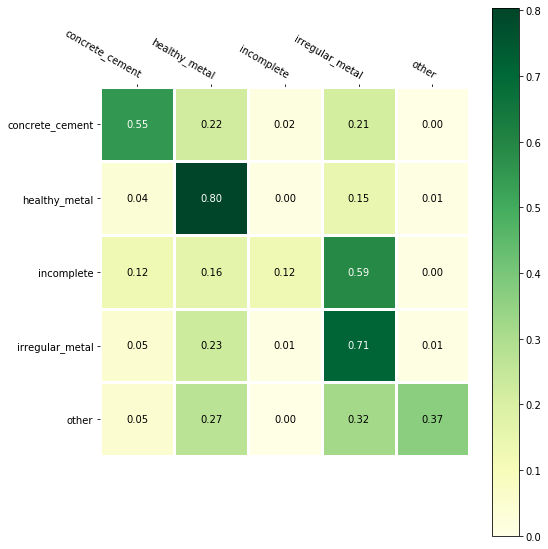

In [18]:
predicted_labels = clf.predict(features_test)
cm = confusion_matrix(labels_test, predicted_labels)

row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = cm / row_sums


fig, ax = plt.subplots(figsize=(8, 8))
im, cbar = utils.heatmap(cm_norm,  materials.keys(), materials.keys(), ax=ax,
                   cmap="YlGn")
texts = utils.annotate_heatmap(im)

fig.tight_layout()
plt.show()

In [18]:
cv_results = cross_validate(clf, feature_matrix_scaled, labels,
                            cv=5, scoring=('f1_macro', 'f1_micro', 'accuracy', 'balanced_accuracy'),
                            n_jobs=7)

In [19]:
cv_results

{'fit_time': array([101.50503945, 102.39844775,  97.96331024, 105.81739736,
        101.75197816]),
 'score_time': array([4.66424346, 5.91319323, 5.79192734, 4.97813368, 4.65413189]),
 'test_f1_macro': array([0.51189195, 0.52863333, 0.49349474, 0.47847987, 0.50113429]),
 'test_f1_micro': array([0.71366083, 0.72500841, 0.7071693 , 0.70798249, 0.70528798]),
 'test_accuracy': array([0.71366083, 0.72500841, 0.7071693 , 0.70798249, 0.70528798]),
 'test_balanced_accuracy': array([0.49677368, 0.52060085, 0.4791563 , 0.45754876, 0.48350754])}

In [23]:
f1_score(labels_test, predicted_labels, average=None)

array([0.55      , 0.79245283, 0.1958042 , 0.68767586, 0.4       ])